# Feature Selection & SHAP Analysis

This notebook demonstrates feature selection using FeatureSelection class with simple input/output paths and noise detection parameters.

In [ ]:
# Import required libraries
import sys
import os

# Add the framework_ml root directory to the Python path
path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, path)

import mlarchitect
mlarchitect.load_config('qrt-2020', filepath=path)

from mlarchitect.feature_selection import FeatureSelection
from mlarchitect.model_config_class import configs

# Additional imports for better visualizations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set up better plot styling
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

c:\Users\Max\.conda\envs\qrt_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Import and Creating New Features

We'll use the data loaded by FeatureSelection to create new features. First we initialize FeatureSelection with our parameters:

In [2]:
# Define paths and parameters
input_path = 'processed/v1'
input_name = 'feature_selection'
output_path = 'feature_selection/v1'

# Initialize feature selection with parameters
fs = FeatureSelection(
    input_path=input_path,
    output_path=output_path,
    name=input_name,
    correlation_threshold=1,
    subsample_ratio=1,
    top_features_ratio=1,
    noise_std_threshold=3.0,
    noise_outlier_ratio=0.1,
)

# Display initial data info
print(f"Initial dataset shape: {fs.data.shape}")

2025-04-01 22:52:34,068 - jhkaggle.feature_selection - INFO - Initializing FeatureSelection with name: feature_selection
2025-04-01 22:52:34,071 - jhkaggle.feature_selection - INFO - Output directory set to: C:\Users\Max\OneDrive\ULTRA NICE\ML Competition\QRT Challenge 2020\data\feature_selection/v1
2025-04-01 22:52:34,981 - jhkaggle.feature_selection - INFO - Data loaded during initialization: 297025 rows, 157 columns


Initial dataset shape: (297025, 157)


### Creating Features with custom_transform

In [23]:
# def create_features(df):
#     result = pd.DataFrame()
    
#     result['RET_SUM'] = df['RET_1'] + df['RET_2'] + df['RET_3']
    
#     return result

# # Apply the transformation - note that we don't specify df_input anymore
# fs.custom_transform(
#     transform_func=create_features,
#     features_to_transform=None,  # List of features to transform or None for all numeric columns
#     new_feature_prefix='test:',    # Optional prefix for new features
#     save_transform=True,         # Whether to save the transformation
#     transform_name='test'        # Name for this transformation
# )

# print(f"Data shape after statistical features: {fs.data.shape}")

In [24]:
# fs.data['test:RET_SUM'] 

## Exclude Features from Testing

Here we can specify features to exclude from the testing process without removing them from the dataset.

In [25]:
# fs.exclude_features(['RET_20'])

## Run Feature Testing

Now we run feature selection without the excluded features.

In [3]:
# Run feature selection on the data (which now excludes the features we specified)
selected_features = fs.run(model_name='xgboost', cv_column='DATE', cv_folds=4)

2025-04-01 22:52:40,415 - jhkaggle.feature_selection - INFO - Starting feature selection pipeline: feature_selection
2025-04-01 22:52:40,416 - jhkaggle.feature_selection - INFO - Using time-series handling with cv_column='DATE'
2025-04-01 22:52:40,417 - jhkaggle.feature_selection - INFO - Loading data...
2025-04-01 22:52:40,416 - jhkaggle.feature_selection - INFO - Using time-series handling with cv_column='DATE'
2025-04-01 22:52:40,417 - jhkaggle.feature_selection - INFO - Loading data...
2025-04-01 22:52:41,072 - jhkaggle.feature_selection - INFO - Data loaded successfully: 297025 rows, 157 columns
2025-04-01 22:52:41,290 - jhkaggle.feature_selection - INFO - X shape: (297025, 156), y shape: (297025,)
2025-04-01 22:52:41,291 - jhkaggle.feature_selection - INFO - Removing highly correlated features...
2025-04-01 22:52:41,377 - jhkaggle.feature_selection - INFO - Calculating correlation matrix for 156 numerical features
2025-04-01 22:53:02,322 - jhkaggle.feature_selection - INFO - No h

## Step 2: Examine Feature Selection Results

Here we analyze what features were removed due to:
- High correlation with other features (redundant information)
- Excessive noise or outliers (potentially unreliable signals)

We also display the top features ranked by importance according to the XGBoost model.

In [4]:
# Display detailed feature selection results
removed_features = fs.get_removed_features()

print("Feature Selection Results:")
print("-" * 50)
print(f"Total features removed: {len(removed_features['correlated']) + len(removed_features['noisy'])}")
print(f"- {len(removed_features['correlated'])} correlated features (correlation > {fs.correlation_threshold})")
if removed_features['correlated']:
    print("\nTop 10 correlated features removed:")
    print("\n".join(f"- {f}" for f in removed_features['correlated'][:10]))

print(f"\n- {len(removed_features['noisy'])} noisy features")
print(f"  (>{fs.noise_outlier_ratio*100}% values beyond {fs.noise_std_threshold} standard deviations)")
if removed_features['noisy']:
    print("\nTop 5 noisy features removed:")
    print("\n".join(f"- {f}" for f in removed_features['noisy'][:5]))

print(f"\nSelected {len(fs.data.columns)} features out of {len(fs.data.columns) + len(removed_features['correlated']) + len(removed_features['noisy'])} total features")

print("\nTop 15 selected features by importance:")
display(fs.feature_importance.head(15))

Feature Selection Results:
--------------------------------------------------
Total features removed: 4
- 0 correlated features (correlation > 1)

- 4 noisy features
  (>10.0% values beyond 3.0 standard deviations)

Top 5 noisy features removed:
- stock_comparison_features:VOLUME_20_rel_vol
- stock_comparison_features:VOLUME_10_rel_vol
- stock_comparison_features:VOLUME_1_rel_vol
- stock_comparison_features:VOLUME_5_rel_vol

Selected 157 features out of 161 total features

Top 15 selected features by importance:


Feature  Importance  \
96              date_comparison_features:market_regime    0.020020   
131        stock_comparison_features:RET_1_sector_mean    0.014512   
0                                                 DATE    0.014416   
2                                             INDUSTRY    0.013081   
132         stock_comparison_features:RET_1_sector_std    0.013056   
136  stock_comparison_features:RET_1_industry_group...    0.013029   
135  stock_comparison_features:RET_1_industry_group...    0.012209   
5                                         SUB_INDUSTRY    0.011596   
147                         temporal_features:BB_UPPER    0.010638   
49                basic_statistical_features:RET_max_5    0.010632   
150                      temporal_features:BB_POSITION    0.010467   
148                         temporal_features:BB_LOWER    0.009686   
117     stock_comparison_features:VOLUME_1_sector_rank    0.009528   
137      stock_comparison_features:RET_1_industry_mean    0.009476   
138       stock_comparison_features:RET_1_industry_std    0.009209   

     Importance_Normalized  Rank  
96                2.001976     1  
131               1.451203     2  
0                 1.441564     3  
2                 1.308079     4  
132               1.305639     5  
136               1.302902     6  
135               1.220863     7  
5                 1.159557     8  
147               1.063791     9  
49                1.063173    10  
150               1.046659    11  
148               0.968587    12  
117               0.952771    13  
137               0.947650    14  
138               0.920931    15

## Step 3: Prepare Data for SHAP Analysis

SHAP (SHapley Additive exPlanations) is an approach to explain the output of machine learning models. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In this step, we prepare a subset of data containing only the top features for SHAP analysis to make the computation more efficient.

In [ ]:
# Configure parameters for SHAP analysis
# These parameters will be used consistently throughout the notebook
top_k = 150  # Number of top features to analyze
n_samples = 200000  # Number of samples to use for SHAP analysis
num_plots = 12  # Number of plots to generate for dependence and force plots

# Get top K features by importance
top_features = fs.feature_importance.head(top_k)['Feature'].tolist()
print(f"Analyzing the top {top_k} features with SHAP using {n_samples} samples")

# Create a subset of data for SHAP analysis
X_subset = fs.data[top_features].head(n_samples)
y_subset = fs.data[mlarchitect.mlarchitect_config['TARGET_NAME']].head(n_samples)

print(f"\nSample data shape: {X_subset.shape}")
# Fix the formatting issue by converting to a string representation first
target_counts = y_subset.value_counts(normalize=True) * 100
print(f"Target distribution:")
for label, percentage in target_counts.items():
    print(f"{label}: {percentage:.2f}%")

Analyzing the top 150 features with SHAP using 200000 samples

Sample data shape: (200000, 150)
Target distribution:
True: 50.14%
False: 49.86%


## Step 4: Generate SHAP Summary Plots

### Understanding SHAP Summary Plots:

1. **SHAP Bar Plot**: Shows the average magnitude of feature importance across all samples.
   - Each bar represents how much a feature impacts the model output on average.
   - Longer bars indicate features with greater overall impact on predictions.

2. **SHAP Beeswarm Plot**: Shows the distribution of SHAP values for each feature.
   - Each dot represents a single sample in the dataset.
   - Position on x-axis: SHAP value (impact on model output)
   - Color: Feature value (red = high, blue = low)
   - This plot reveals how the value of a feature affects its impact on the prediction.

These visualizations help us understand not just which features are important (like traditional feature importance), but also how they affect predictions and under what conditions.

In [6]:
# Train a model for SHAP analysis on the subset
model_name = "xgboost"  # Using XGBoost for SHAP analysis
print(f"Training a {model_name} model for SHAP analysis...")

try:
    # Generate SHAP values using the feature selection class
    shap_values, explainer = fs.generate_shap_analysis(
        X=X_subset, 
        y=y_subset, 
        model_name=model_name,
        plot=False 
    )
    
    if shap_values is None:
        print("SHAP analysis failed. Please check the data and model configuration.")
    else:
        print(f"SHAP analysis completed successfully with {len(shap_values)} values")
except Exception as e:
    print(f"Error in SHAP analysis: {str(e)}")
    shap_values = None

2025-04-01 22:55:10,590 - jhkaggle.feature_selection - INFO - Starting SHAP analysis using xgboost model
2025-04-01 22:55:10,591 - jhkaggle.feature_selection - INFO - Using all 200000 samples for SHAP analysis
2025-04-01 22:55:10,595 - jhkaggle.feature_selection - INFO - Training model for SHAP analysis...


Training a xgboost model for SHAP analysis...


2025-04-01 22:55:23,275 - jhkaggle.feature_selection - INFO - Creating SHAP explainer...
2025-04-01 22:57:41,218 - jhkaggle.feature_selection - INFO - Created TreeExplainer successfully
2025-04-01 22:57:41,221 - jhkaggle.feature_selection - INFO - SHAP plots will be saved to C:\Users\Max\OneDrive\ULTRA NICE\ML Competition\QRT Challenge 2020\data\feature_selection/v1\feature_selection_20250401_225234\shap_plots
2025-04-01 22:57:41,223 - jhkaggle.feature_selection - INFO - Generating SHAP summary bar plot
2025-04-01 22:57:42,154 - jhkaggle.feature_selection - INFO - Generating SHAP summary dot plot
2025-04-01 22:59:17,610 - jhkaggle.feature_selection - INFO - SHAP analysis completed successfully


SHAP analysis completed successfully with 200000 values


### SHAP Summary Bar Plot

This plot shows the average magnitude of SHAP values for each feature (i.e., the average impact on model output).

**How to interpret:**
- Features are ranked by their average impact on the model's prediction
- Longer bars indicate features with greater overall impact on predictions
- This gives us a clear ranking of feature importance based on actual model behavior

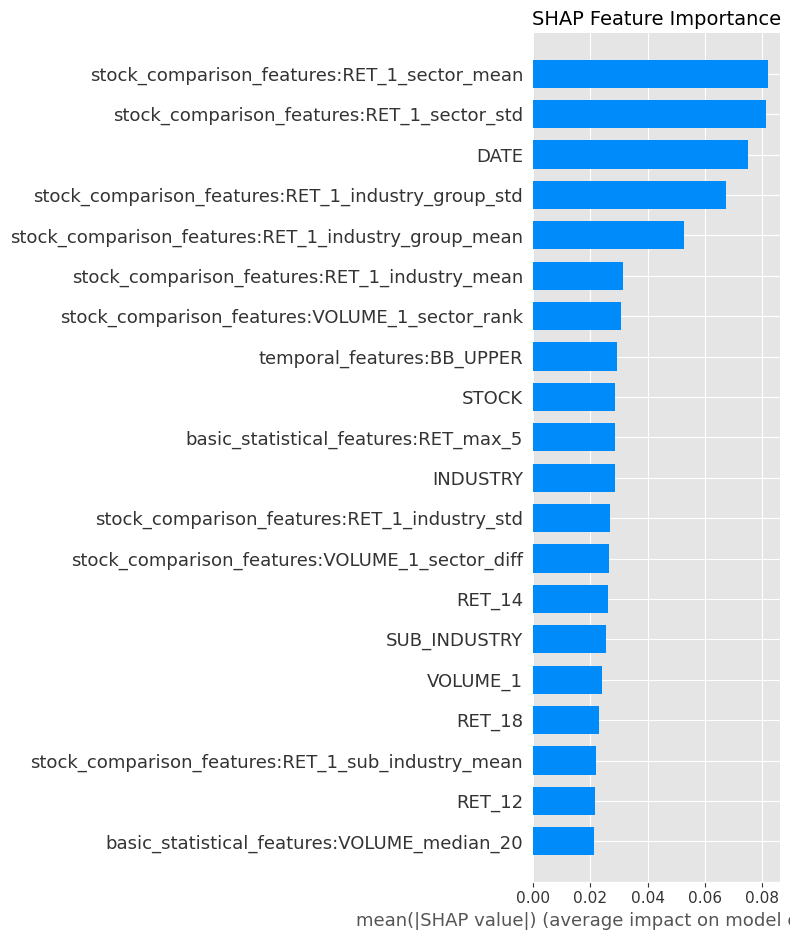

In [7]:
# Create SHAP summary bar plot with error handling
if shap_values is not None:
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_subset, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate SHAP bar plot: SHAP values not available")

### SHAP Summary Beeswarm Plot

This plot shows the distribution of SHAP values for each feature across all examples in the dataset.

**How to interpret:**
- Each point represents a single observation in the dataset
- Position on x-axis: SHAP value (positive = increases prediction, negative = decreases prediction)
- Color: Feature value (red = high value, blue = low value)
- Pattern of red/blue: Shows how feature values relate to impact
  - Red points clustered on right side: High feature values increase the prediction
  - Blue points clustered on right side: Low feature values increase the prediction
  - Mixed colors: Impact depends on interaction with other features

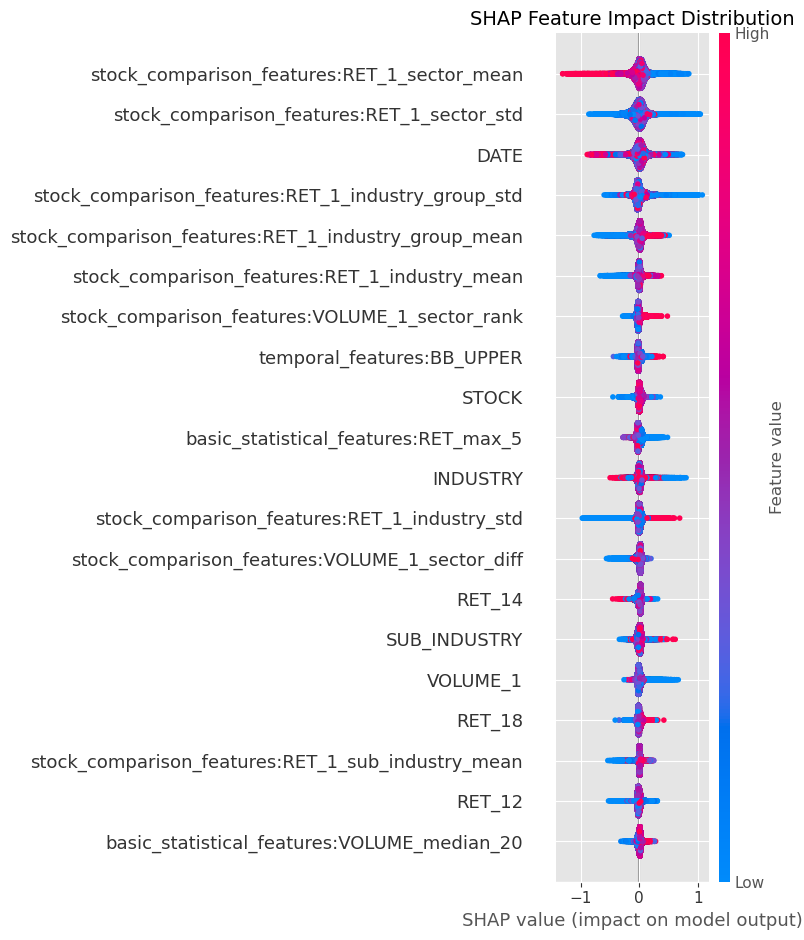

In [8]:
# Create SHAP summary beeswarm plot with error handling
if shap_values is not None:
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_subset, show=False)
    plt.title("SHAP Feature Impact Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate SHAP beeswarm plot: SHAP values not available")

## Step 5: Generate SHAP Dependence Plots

### Understanding SHAP Dependence Plots:

SHAP dependence plots show how a feature's value affects its impact on the model prediction, while accounting for interaction effects with other features.

**How to interpret:**
- X-axis: The value of the feature
- Y-axis: The SHAP value (impact on prediction)
- Each point: A single observation in the dataset
- Color: Value of another feature that most strongly interacts with the main feature
- Trend: Shows the relationship between feature value and its impact on model output
- Vertical spread: Indicates interaction effects with other features

Below, we'll generate dependence plots for the top 5 most important features.

In [9]:
# Get top 5 features for dependence plots
if shap_values is not None and isinstance(shap_values, np.ndarray):
    # Calculate mean absolute SHAP values for each feature
    feature_importance = np.abs(shap_values).mean(0)
    # Get indices of top features to display
    top_indices = np.argsort(-feature_importance)[:num_plots]
    top_features_to_display = [X_subset.columns[i] for i in top_indices]
    
    print(f"Top {num_plots} features for dependence plots:")
    for i, feature in enumerate(top_features_to_display, 1):
        print(f"{i}. {feature}")
else:
    top_features_to_display = []
    print("Cannot determine top features: SHAP values not available")

Top 12 features for dependence plots:
1. stock_comparison_features:RET_1_sector_mean
2. stock_comparison_features:RET_1_sector_std
3. DATE
4. stock_comparison_features:RET_1_industry_group_std
5. stock_comparison_features:RET_1_industry_group_mean
6. stock_comparison_features:RET_1_industry_mean
7. stock_comparison_features:VOLUME_1_sector_rank
8. temporal_features:BB_UPPER
9. STOCK
10. basic_statistical_features:RET_max_5
11. INDUSTRY
12. stock_comparison_features:RET_1_industry_std


### SHAP Dependence Plots for Top Features

Each plot below shows how a specific feature's value affects its impact on the model prediction.
We examine the top 5 most important features to understand their detailed relationship with model outputs.

<Figure size 1200x600 with 0 Axes>

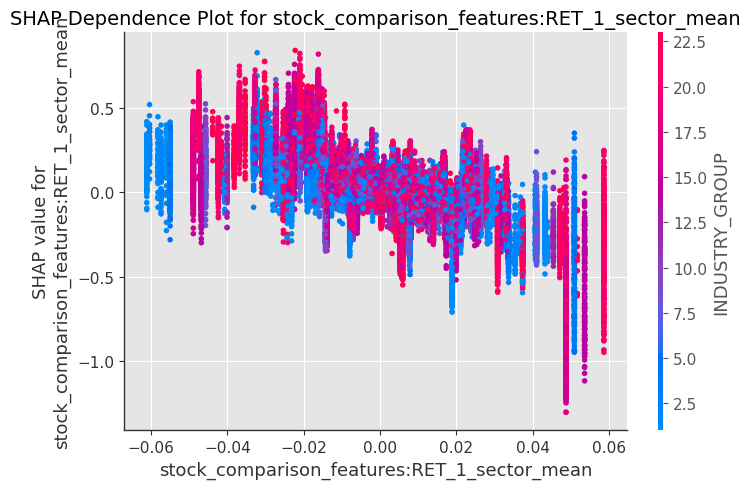

Feature stock_comparison_features:RET_1_sector_mean relationships:
- Linear: negative (higher values → lower predictions) (Correlation: -0.589)
- Squared: weak or complex (possibly non-linear) (Correlation: -0.042)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: 0.008)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

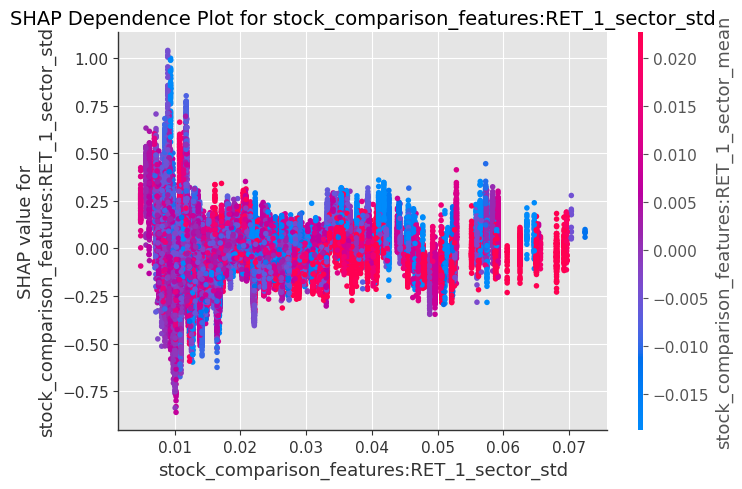

Feature stock_comparison_features:RET_1_sector_std relationships:
- Linear: weak or complex (possibly non-linear) (Correlation: 0.184)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.148)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: 0.184)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

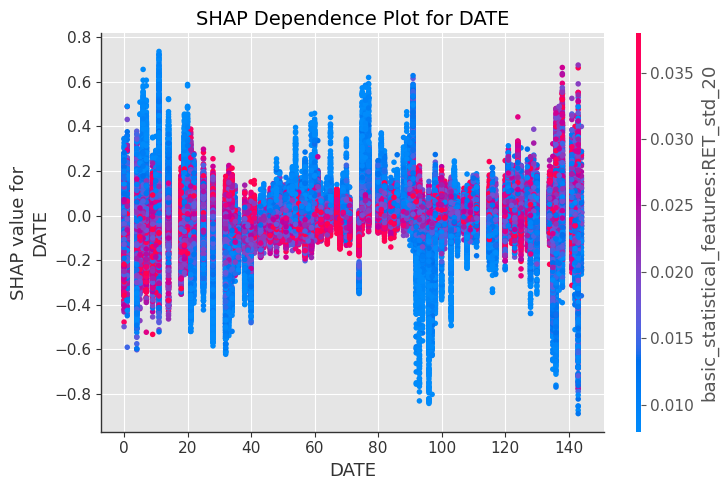

Feature DATE relationships:
- Linear: weak or complex (possibly non-linear) (Correlation: 0.103)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.089)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: 0.103)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

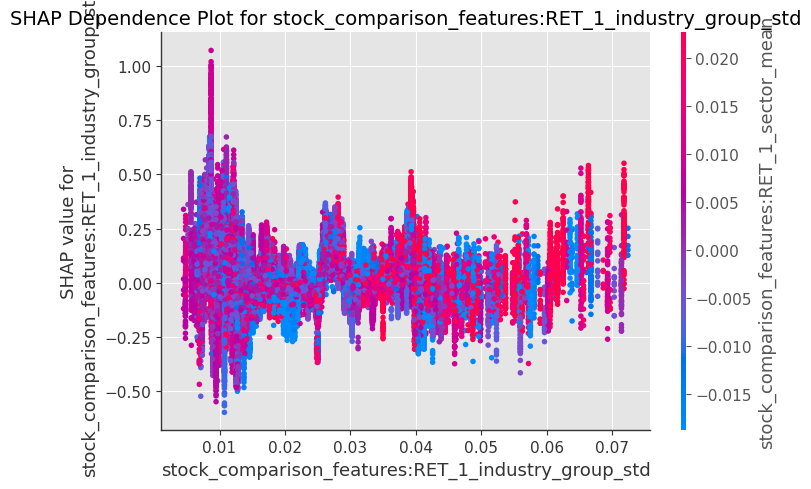

Feature stock_comparison_features:RET_1_industry_group_std relationships:
- Linear: weak or complex (possibly non-linear) (Correlation: -0.030)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.019)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: -0.032)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

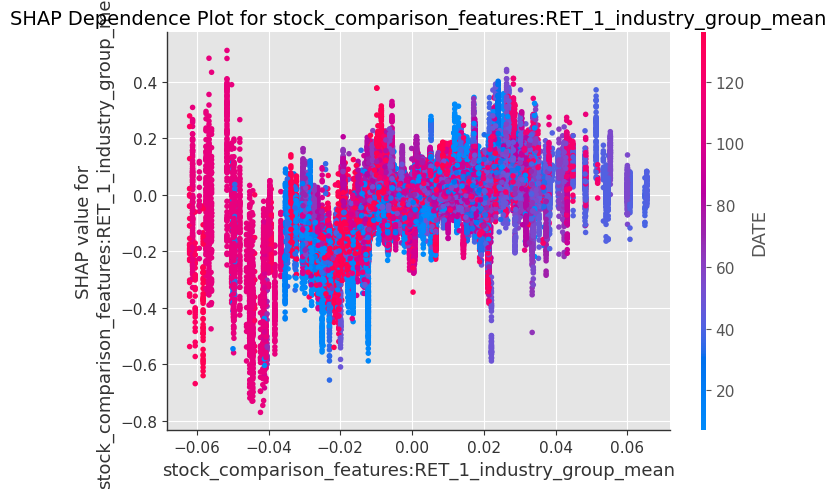

Feature stock_comparison_features:RET_1_industry_group_mean relationships:
- Linear: positive (higher values → higher predictions) (Correlation: 0.531)
- Squared: weak or complex (possibly non-linear) (Correlation: -0.138)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: -0.139)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

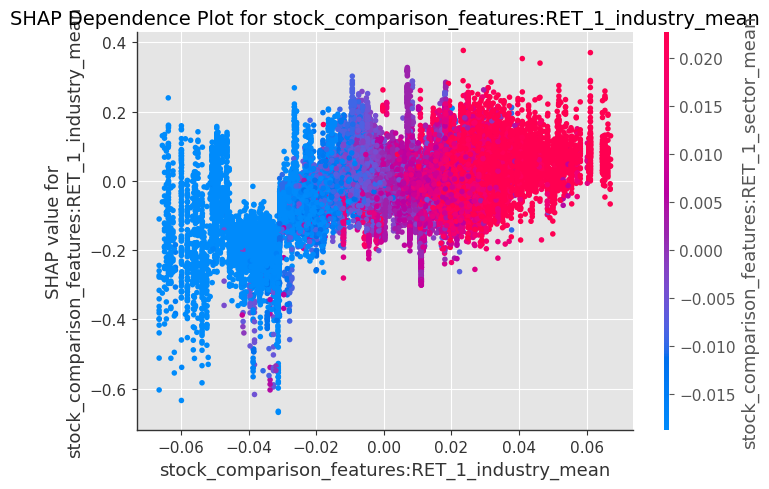

Feature stock_comparison_features:RET_1_industry_mean relationships:
- Linear: positive (higher values → higher predictions) (Correlation: 0.436)
- Squared: weak or complex (possibly non-linear) (Correlation: -0.147)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: -0.123)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

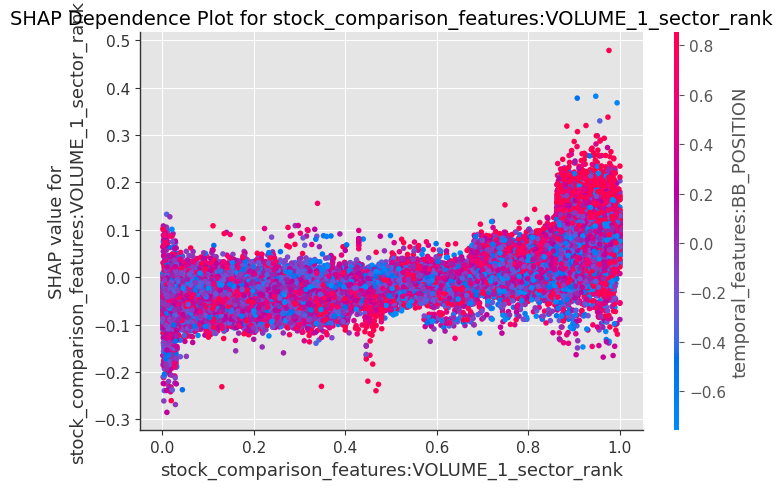

Feature stock_comparison_features:VOLUME_1_sector_rank relationships:
- Linear: positive (higher values → higher predictions) (Correlation: 0.728)
- Squared: positive (higher values → higher predictions) (Correlation: 0.795)
- Logarithmic: positive (higher values → higher predictions) (Correlation: 0.694)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

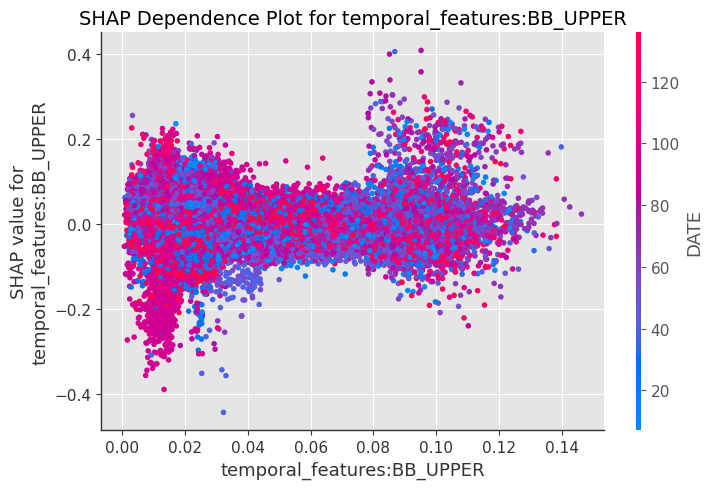

Feature temporal_features:BB_UPPER relationships:
- Linear: negative (higher values → lower predictions) (Correlation: -0.305)
- Squared: negative (higher values → lower predictions) (Correlation: -0.216)
- Logarithmic: negative (higher values → lower predictions) (Correlation: -0.309)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

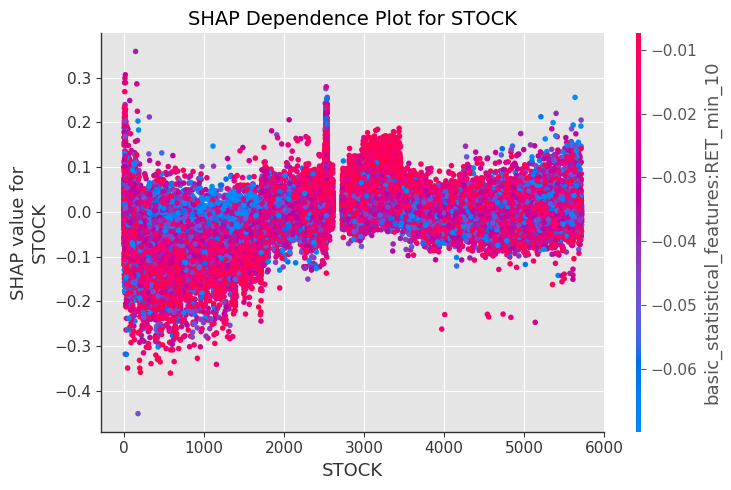

Feature STOCK relationships:
- Linear: positive (higher values → higher predictions) (Correlation: 0.309)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.169)
- Logarithmic: positive (higher values → higher predictions) (Correlation: 0.367)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

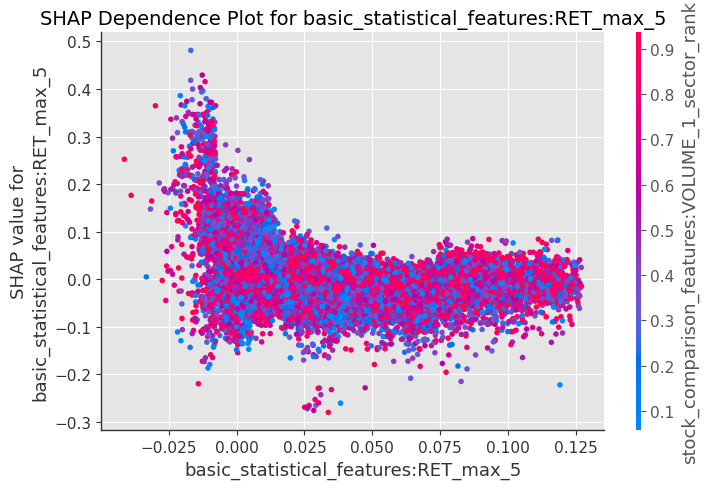

Feature basic_statistical_features:RET_max_5 relationships:
- Linear: negative (higher values → lower predictions) (Correlation: -0.549)
- Squared: negative (higher values → lower predictions) (Correlation: -0.338)
- Logarithmic: negative (higher values → lower predictions) (Correlation: -0.536)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

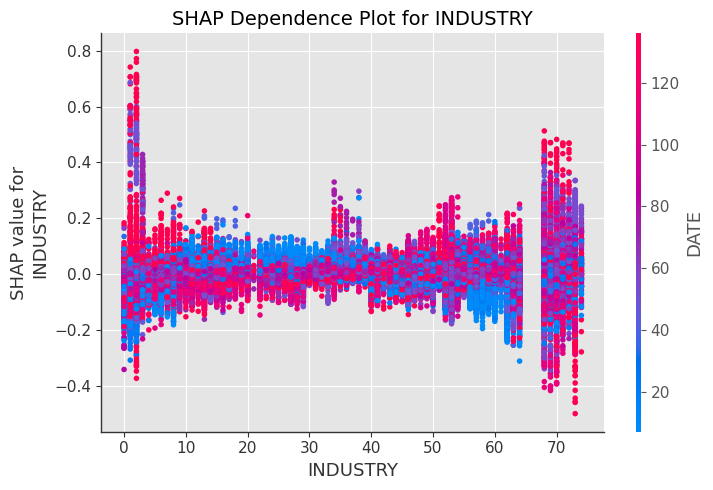

Feature INDUSTRY relationships:
- Linear: weak or complex (possibly non-linear) (Correlation: 0.064)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.020)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: 0.131)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

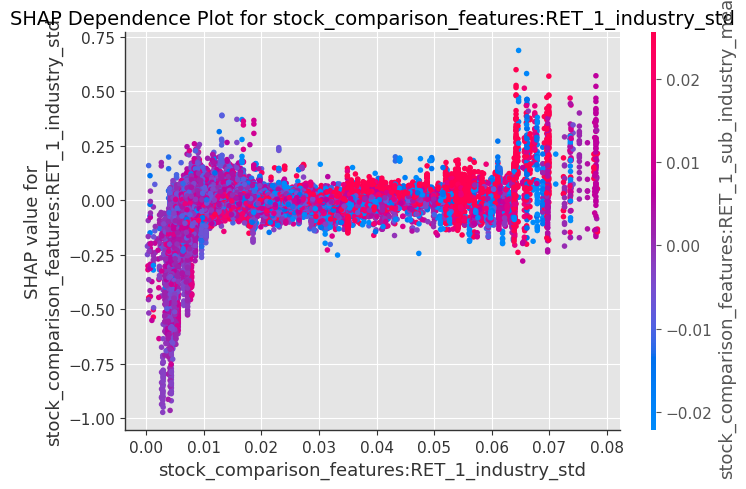

Feature stock_comparison_features:RET_1_industry_std relationships:
- Linear: weak or complex (possibly non-linear) (Correlation: 0.109)
- Squared: weak or complex (possibly non-linear) (Correlation: 0.087)
- Logarithmic: weak or complex (possibly non-linear) (Correlation: 0.109)
--------------------------------------------------


In [10]:
# Define the number of graphs to display
num_graphs_to_display = 10  # Change this value to control the number of graphs displayed

# Create individual dependence plots for top features with error handling
if shap_values is not None and len(top_features_to_display) > 0:
    for i, feature in enumerate(top_features_to_display[:num_plots]):
        plt.figure(figsize=(12, 6))
        shap.dependence_plot(feature, shap_values, X_subset, show=False)
        plt.title(f"SHAP Dependence Plot for {feature}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Add a summary of what we observe in this plot
        try:
            feature_values = X_subset[feature].values
            feature_shap = shap_values[:, list(X_subset.columns).index(feature)]
            
            # Calculate correlation for different transformations
            correlation = np.corrcoef(feature_values, feature_shap)[0, 1]
            squared_correlation = np.corrcoef(feature_values**2, feature_shap)[0, 1]
            log_correlation = np.corrcoef(np.log1p(np.abs(feature_values)), feature_shap)[0, 1]  # log1p for log(1 + |x|)
            
            # Determine relationships
            def describe_relationship(corr):
                if abs(corr) < 0.2:
                    return "weak or complex (possibly non-linear)"
                elif corr > 0:
                    return "positive (higher values → higher predictions)"
                else:
                    return "negative (higher values → lower predictions)"
            
            relationship = describe_relationship(correlation)
            squared_relationship = describe_relationship(squared_correlation)
            log_relationship = describe_relationship(log_correlation)
            
            # Print results
            print(f"Feature {feature} relationships:")
            print(f"- Linear: {relationship} (Correlation: {correlation:.3f})")
            print(f"- Squared: {squared_relationship} (Correlation: {squared_correlation:.3f})")
            print(f"- Logarithmic: {log_relationship} (Correlation: {log_correlation:.3f})")
            print("-" * 50)
        except Exception as e:
            print(f"Could not analyze relationship for {feature}: {str(e)}")
else:
    print("Cannot generate dependence plots: SHAP values or top features not available")

## Step 6: SHAP Force Plot for Individual Predictions

Force plots show how each feature contributes to pushing the model output from the base value (average prediction) to the final prediction for a specific sample.

**How to interpret:**
- Base value: Average model output over the training dataset (middle of the plot)
- Red arrows: Features pushing prediction higher
- Blue arrows: Features pushing prediction lower
- Arrow width: Magnitude of the feature's impact

Below, we'll examine force plots for some representative examples with improved readability.


Sample 161 Force Plot:


<Figure size 1600x500 with 0 Axes>

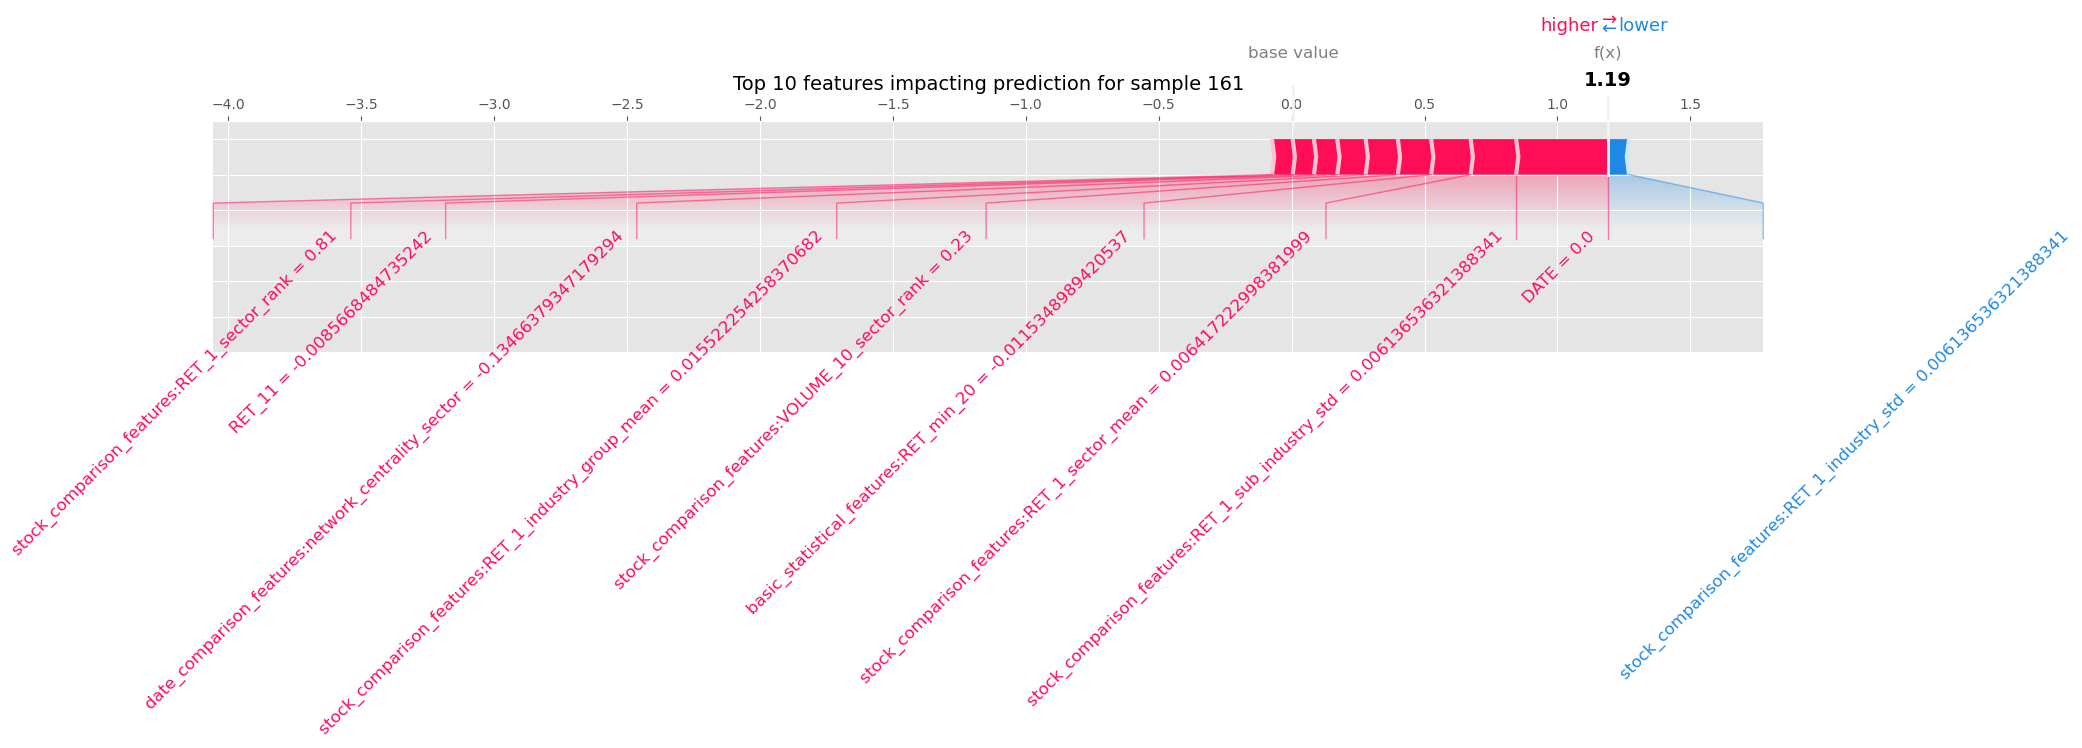

Actual label: Positive
Model leans toward: Positive (SHAP sum: 1.7223)
--------------------------------------------------

Sample 177 Force Plot:


<Figure size 1600x500 with 0 Axes>

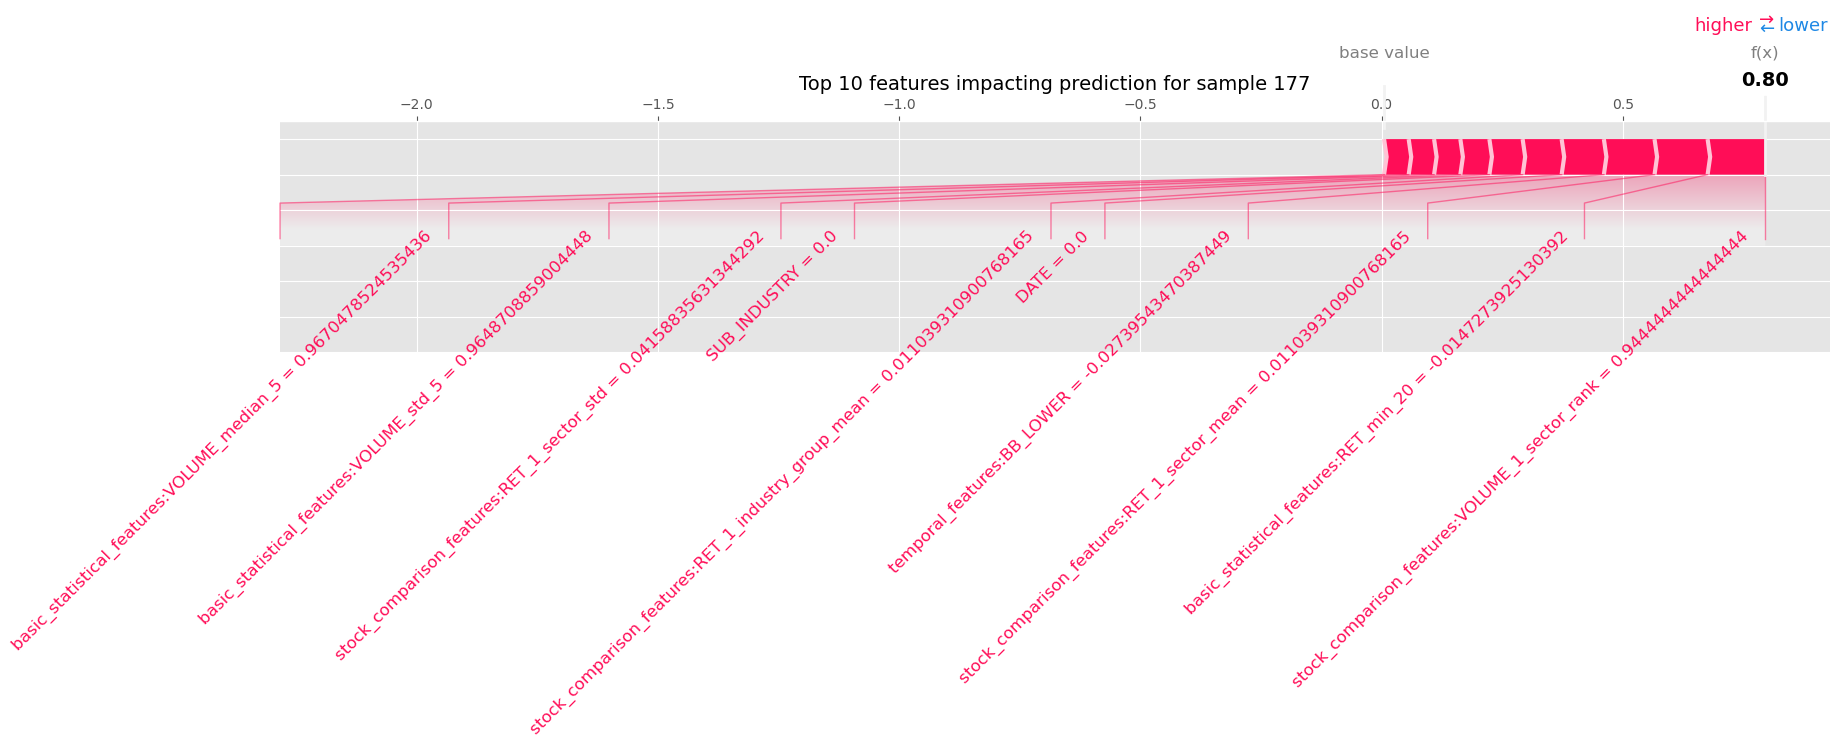

Actual label: Positive
Model leans toward: Positive (SHAP sum: 1.1400)
--------------------------------------------------

Sample 199 Force Plot:


<Figure size 1600x500 with 0 Axes>

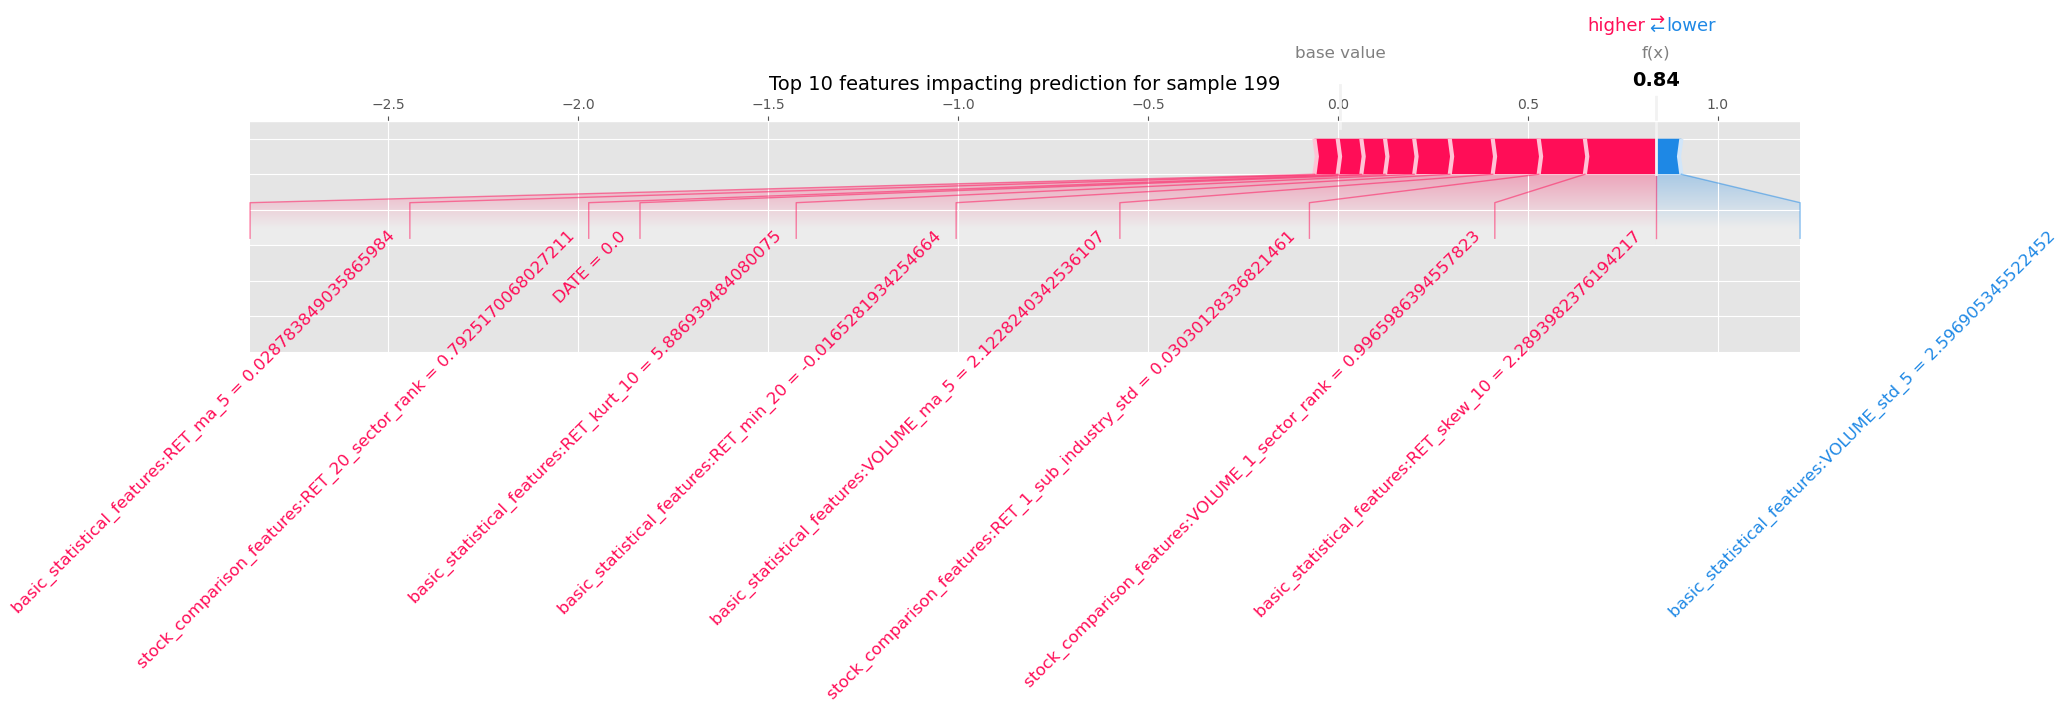

Actual label: Positive
Model leans toward: Positive (SHAP sum: 1.5840)
--------------------------------------------------

Sample 244 Force Plot:


<Figure size 1600x500 with 0 Axes>

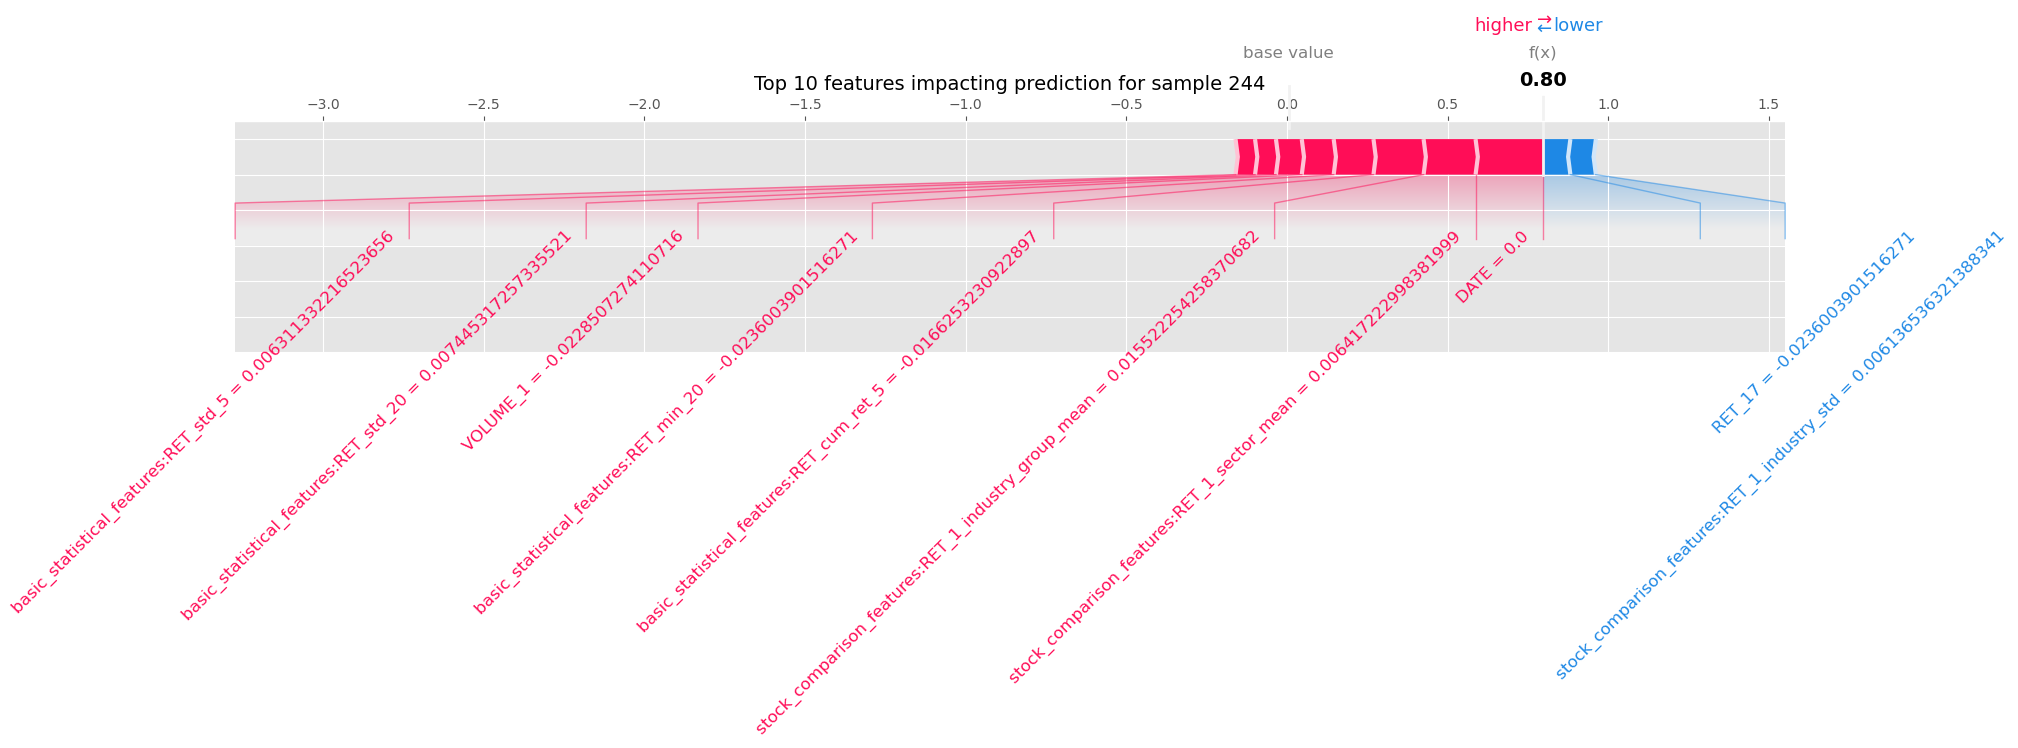

Actual label: Positive
Model leans toward: Positive (SHAP sum: 1.1426)
--------------------------------------------------

Sample 252 Force Plot:


<Figure size 1600x500 with 0 Axes>

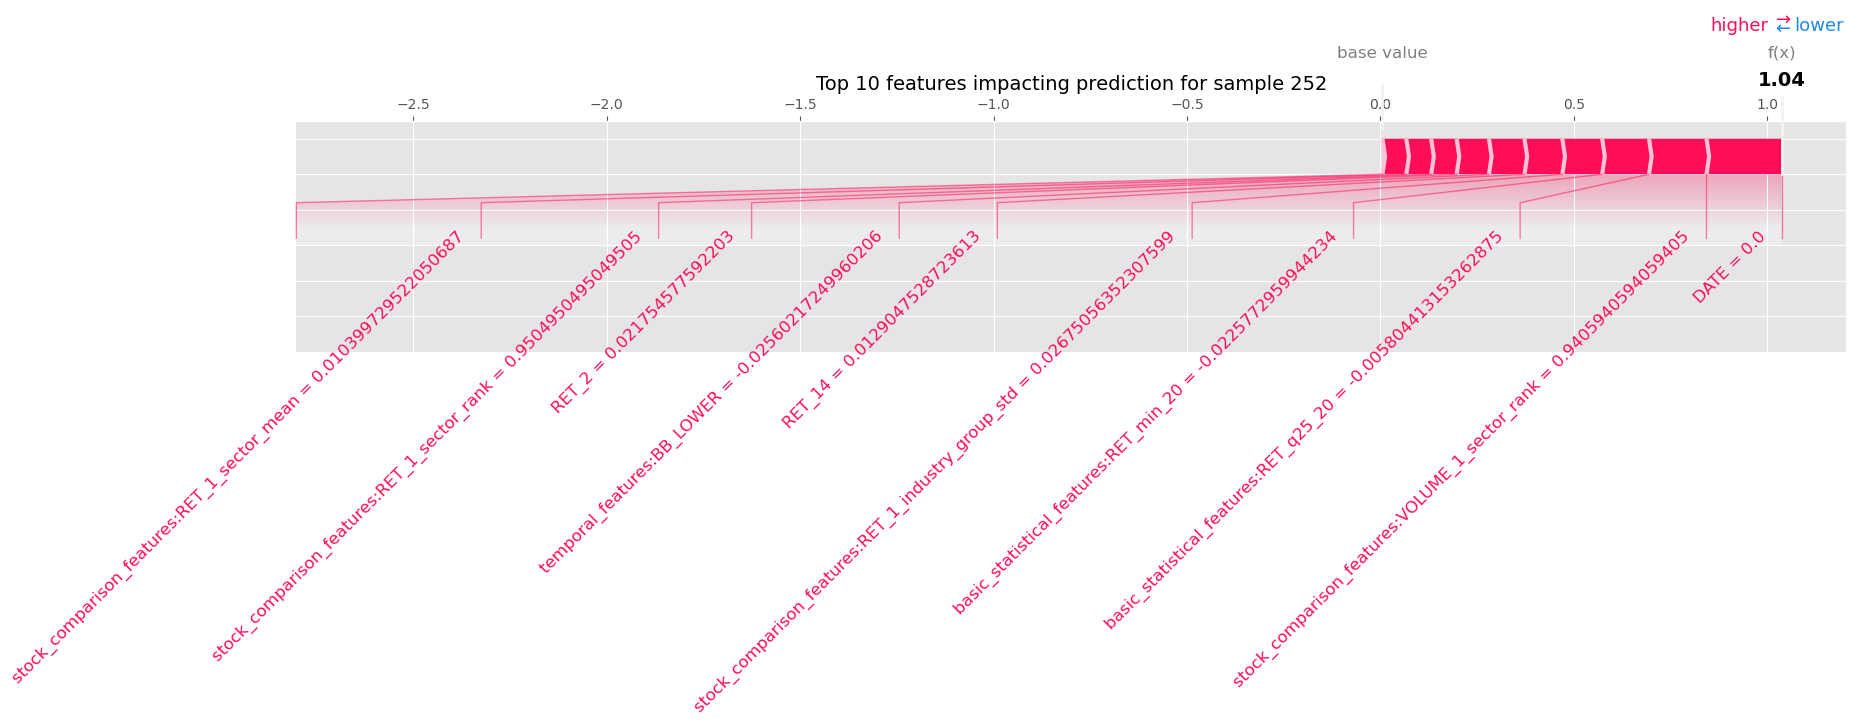

Actual label: Positive
Model leans toward: Positive (SHAP sum: 1.3599)
--------------------------------------------------

Sample 8 Force Plot:


<Figure size 1600x500 with 0 Axes>

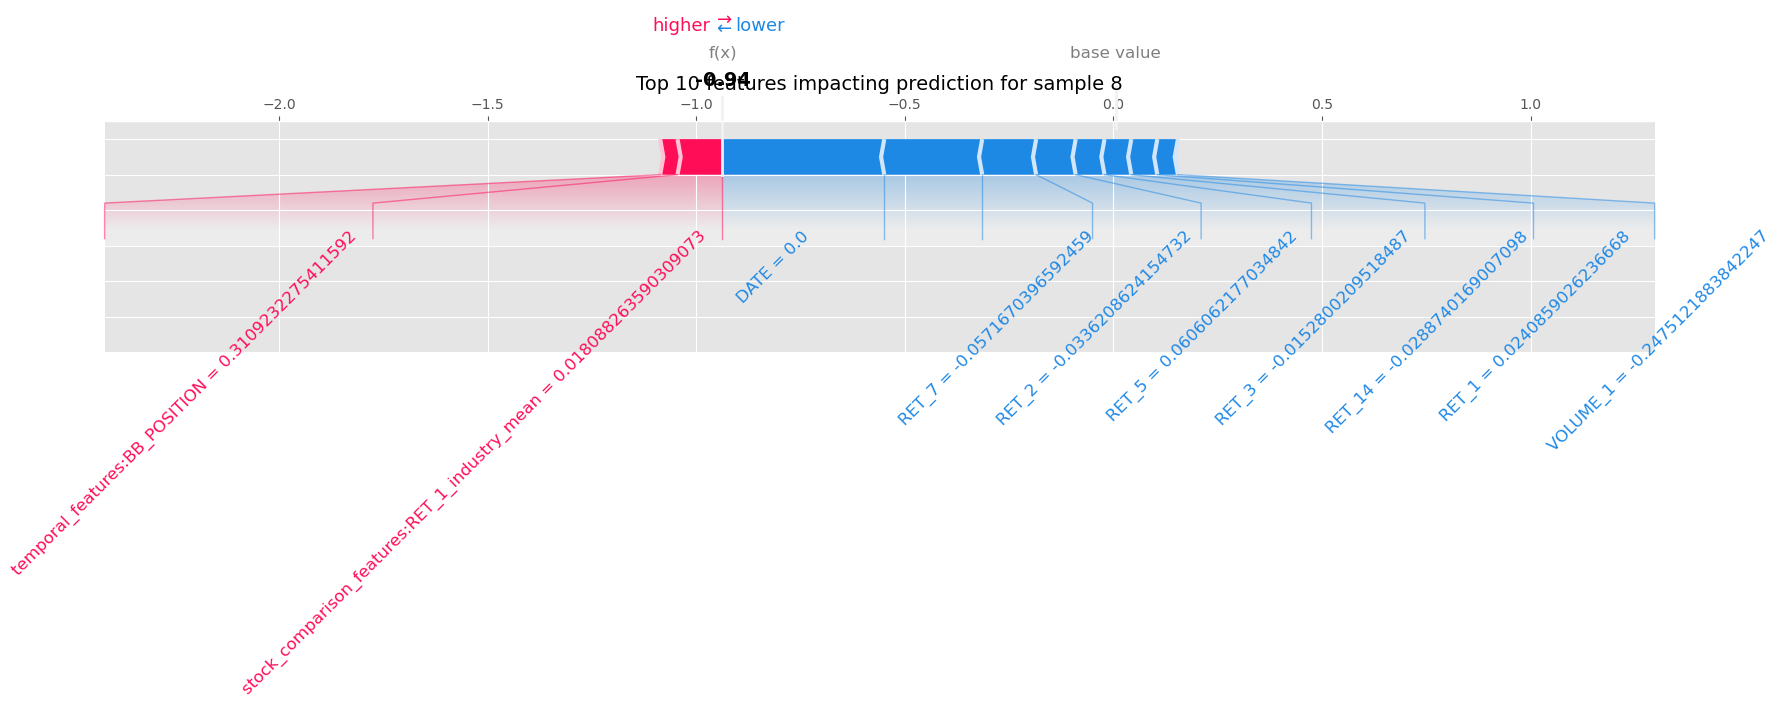

Actual label: Negative
Model leans toward: Negative (SHAP sum: -1.3820)
--------------------------------------------------

Sample 16 Force Plot:


<Figure size 1600x500 with 0 Axes>

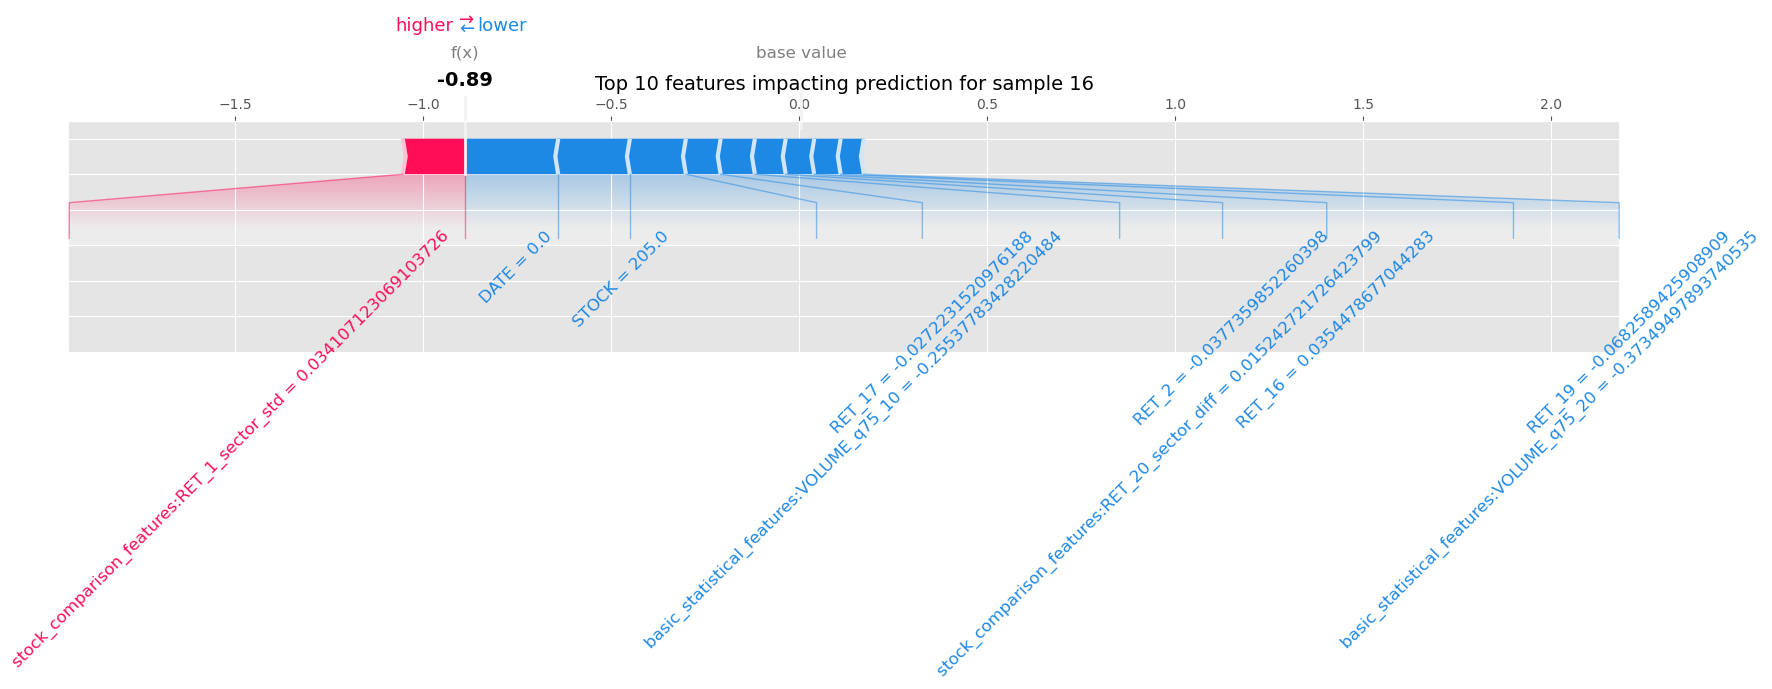

Actual label: Negative
Model leans toward: Negative (SHAP sum: -1.3057)
--------------------------------------------------

Sample 24 Force Plot:


<Figure size 1600x500 with 0 Axes>

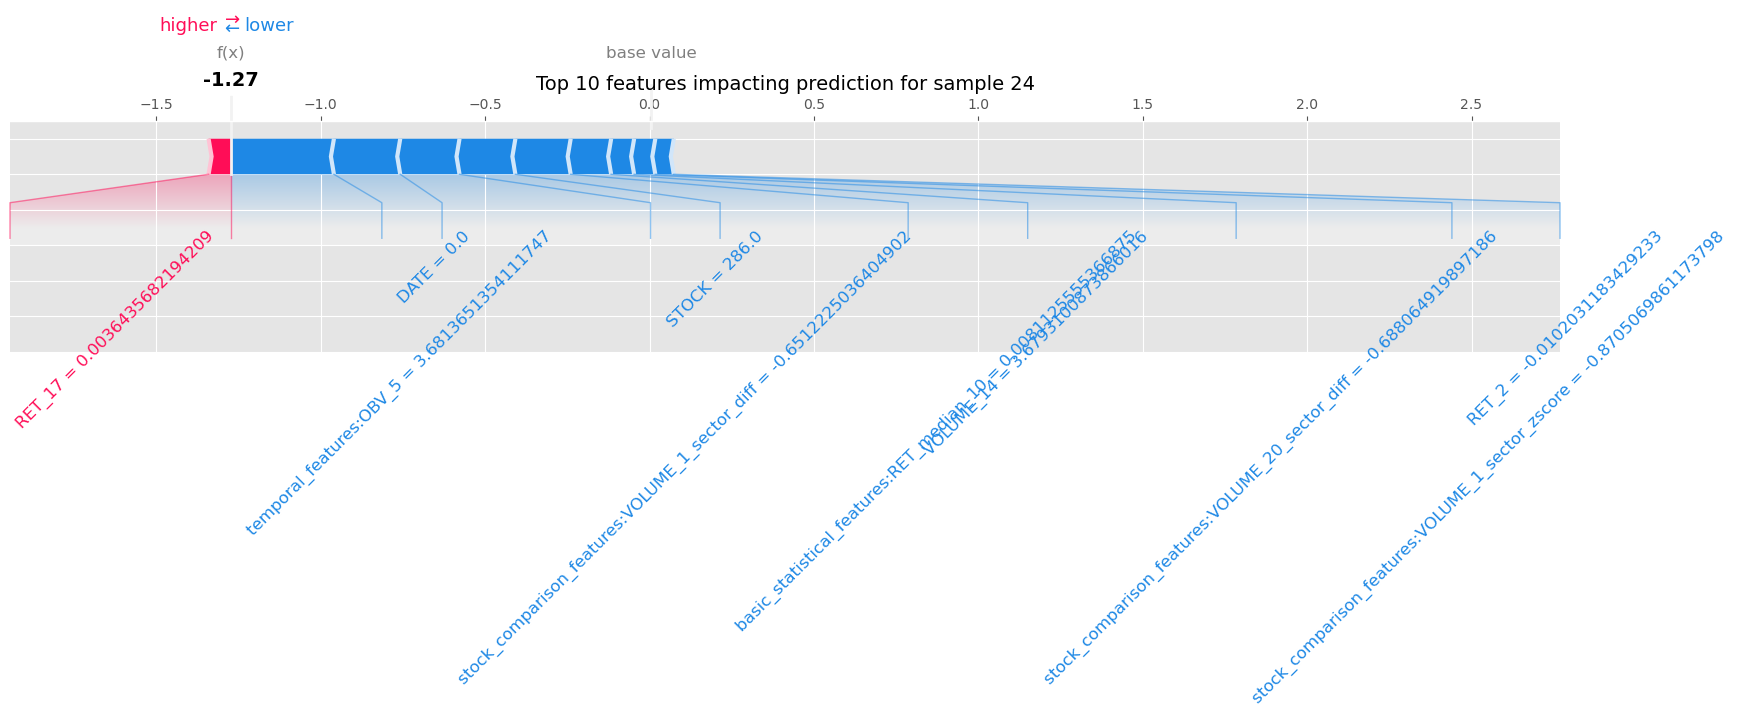

Actual label: Negative
Model leans toward: Negative (SHAP sum: -1.4563)
--------------------------------------------------

Sample 25 Force Plot:


<Figure size 1600x500 with 0 Axes>

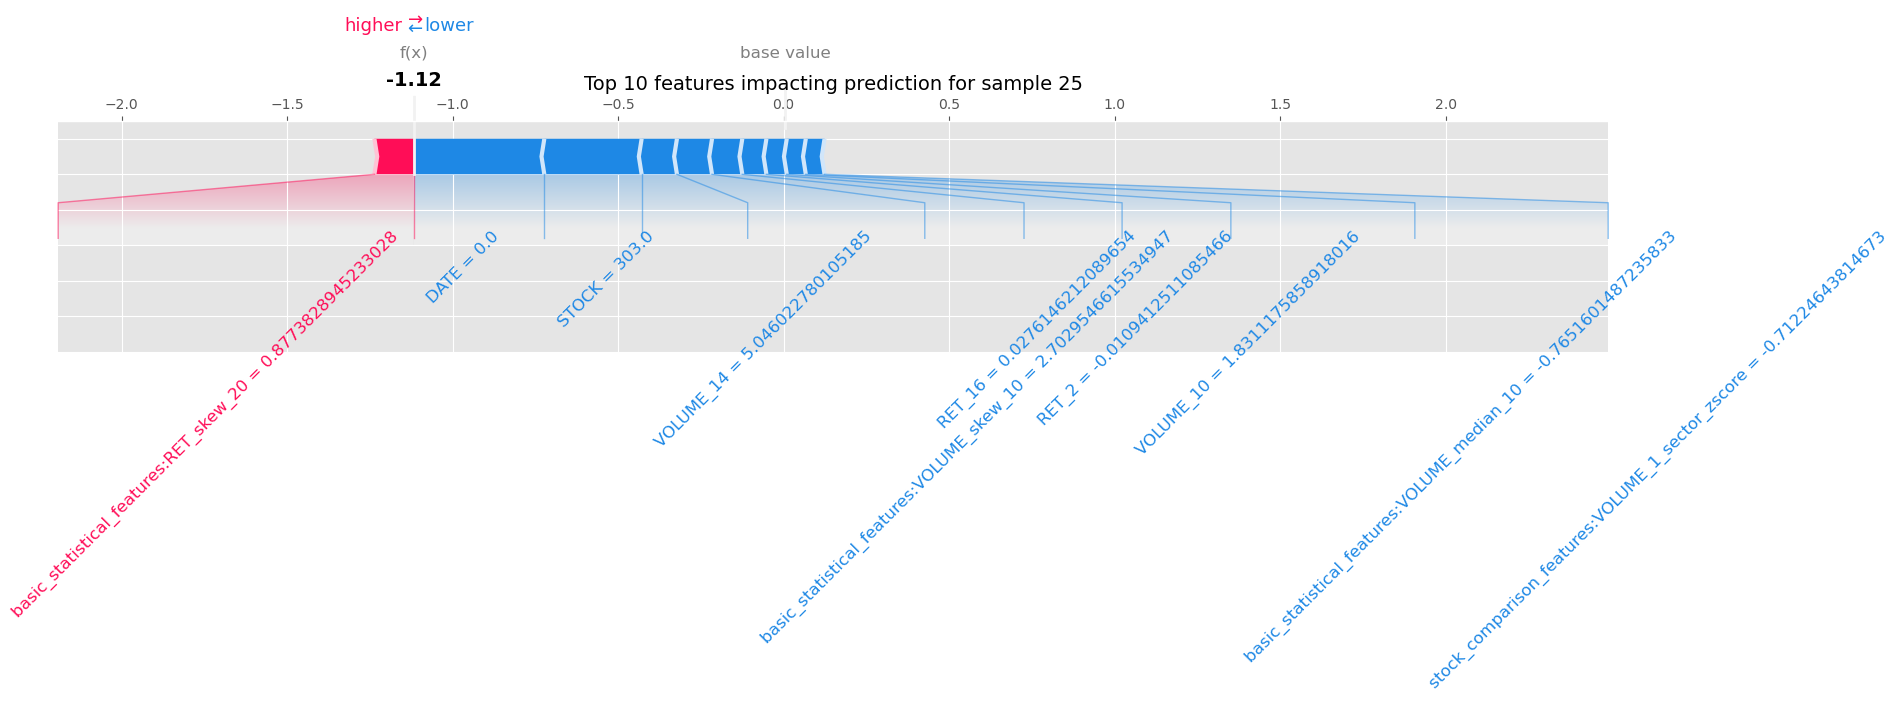

Actual label: Negative
Model leans toward: Negative (SHAP sum: -1.3759)
--------------------------------------------------

Sample 30 Force Plot:


<Figure size 1600x500 with 0 Axes>

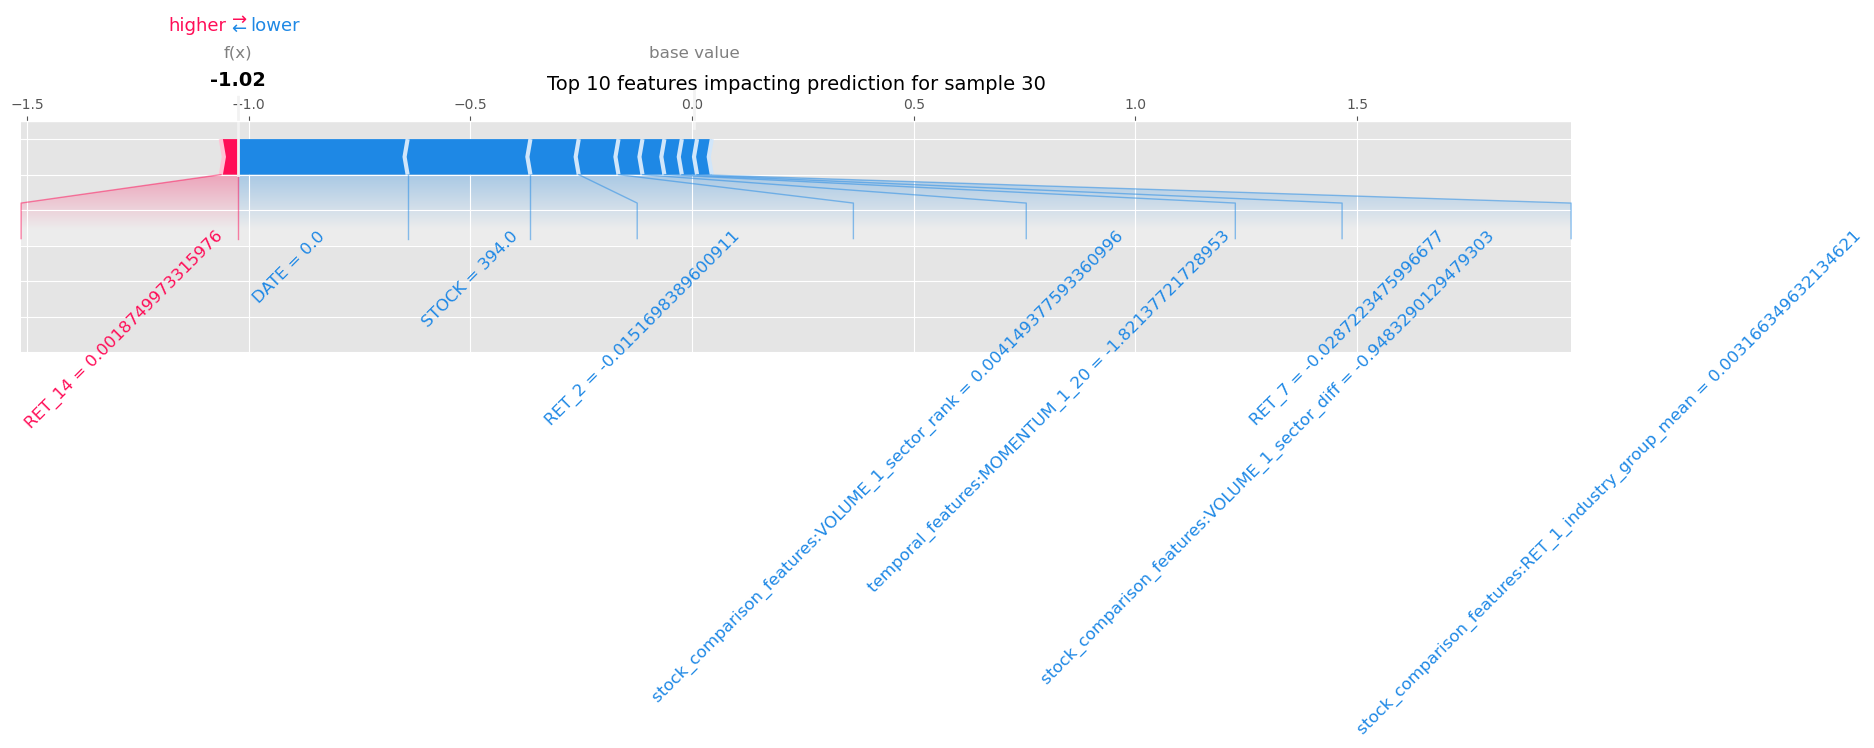

Actual label: Negative
Model leans toward: Negative (SHAP sum: -1.1412)
--------------------------------------------------


In [11]:
# Generate force plots for a specified number of individual predictions with improved readability
if shap_values is not None and explainer is not None:
    # Define how many samples to plot
    num_plots = 10  # Change this value to control the number of graphs to plot

    # Get a few representative samples (predicted positive and negative)
    sample_indices = []
    if hasattr(explainer, 'expected_value'):
        base_value = explainer.expected_value
        if isinstance(base_value, list):
            base_value = base_value[1 if len(base_value) > 1 else 0]
            
        # Find examples with strong positive and negative predictions
        shap_sums = shap_values.sum(1)
        pos_indices = np.where(shap_sums > np.percentile(shap_sums, 95))[0][:num_plots // 2]
        neg_indices = np.where(shap_sums < np.percentile(shap_sums, 5))[0][:num_plots // 2]
        sample_indices = list(pos_indices) + list(neg_indices)
    else:
        # Fallback if expected_value not available
        sample_indices = list(range(num_plots))
        base_value = 0
    
    # Define how many top features to show in each force plot
    max_features_to_show = 10  # Limit the number of features shown to improve readability
    
    # Create force plots for selected samples with improved readability
    for idx in sample_indices:
        print(f"\nSample {idx} Force Plot:")
        
        # Sort features by absolute SHAP value impact
        feature_importance = np.abs(shap_values[idx])
        top_feature_indices = np.argsort(-feature_importance)[:max_features_to_show]
        
        # Create a smaller dataset with only the most important features for this sample
        feature_names = list(X_subset.columns)
        selected_features = [feature_names[i] for i in top_feature_indices]
        
        # Create reduced data and SHAP values for this sample
        reduced_data = X_subset.iloc[[idx]][selected_features]
        reduced_shap_values = shap_values[idx][top_feature_indices]
        
        # Create a matplotlib figure with increased size for better readability
        plt.figure(figsize=(16, 5))
        shap.force_plot(
            base_value, 
            reduced_shap_values, 
            reduced_data.iloc[0],
            feature_names=selected_features,
            matplotlib=True,
            show=False,
            text_rotation=45  # Rotate feature names for better readability
        )
        plt.title(f"Top {max_features_to_show} features impacting prediction for sample {idx}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Show the total SHAP value and actual label
        actual_label = "Positive" if y_subset.iloc[idx] else "Negative"
        shap_sum = shap_values[idx].sum()
        predicted_label = "Positive" if shap_sum > 0 else "Negative"
        print(f"Actual label: {actual_label}")
        print(f"Model leans toward: {predicted_label} (SHAP sum: {shap_sum:.4f})")
        print("-" * 50)
else:
    print("Cannot generate force plots: SHAP values or explainer not available")

## Step 7: SHAP Interaction Values (Advanced)

SHAP interaction values explain how much of a prediction is due to interactions between pairs of features, beyond their individual main effects.

**Note:** This analysis is computationally expensive and may take time to run for large datasets.

In [12]:
# Optionally compute SHAP interaction values (this may be slow)
compute_interactions = False  # Set to True if you want to run this analysis

if compute_interactions and shap_values is not None and hasattr(explainer, 'shap_interaction_values'):
    try:
        # Take a smaller subset for interaction analysis (it's computationally expensive)
        small_sample = X_subset.iloc[:1000]
        print("Computing SHAP interaction values (this may take several minutes)...")
        interaction_values = explainer.shap_interaction_values(small_sample)
        
        # Visualize the interactions
        plt.figure(figsize=(12, 10))
        shap.summary_plot(interaction_values, small_sample, show=False)
        plt.title("SHAP Interaction Values", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not compute interaction values: {str(e)}")
elif compute_interactions:
    print("Cannot compute interaction values: SHAP values not available or explainer doesn't support it")

2025-04-01 23:01:55,207 - jhkaggle.feature_selection - INFO - Starting SHAP analysis using xgboost model
2025-04-01 23:01:55,209 - jhkaggle.feature_selection - INFO - Using all 200000 samples for SHAP analysis
2025-04-01 23:01:55,212 - jhkaggle.feature_selection - INFO - Training model for SHAP analysis...
2025-04-01 23:02:09,591 - jhkaggle.feature_selection - INFO - Creating SHAP explainer...
2025-04-01 23:04:11,289 - jhkaggle.feature_selection - INFO - Created TreeExplainer successfully
2025-04-01 23:04:11,293 - jhkaggle.feature_selection - INFO - SHAP plots will be saved to C:\Users\Max\OneDrive\ULTRA NICE\ML Competition\QRT Challenge 2020\data\feature_selection/v1\feature_selection_20250401_225234\shap_plots
2025-04-01 23:04:11,295 - jhkaggle.feature_selection - INFO - Generating SHAP summary bar plot


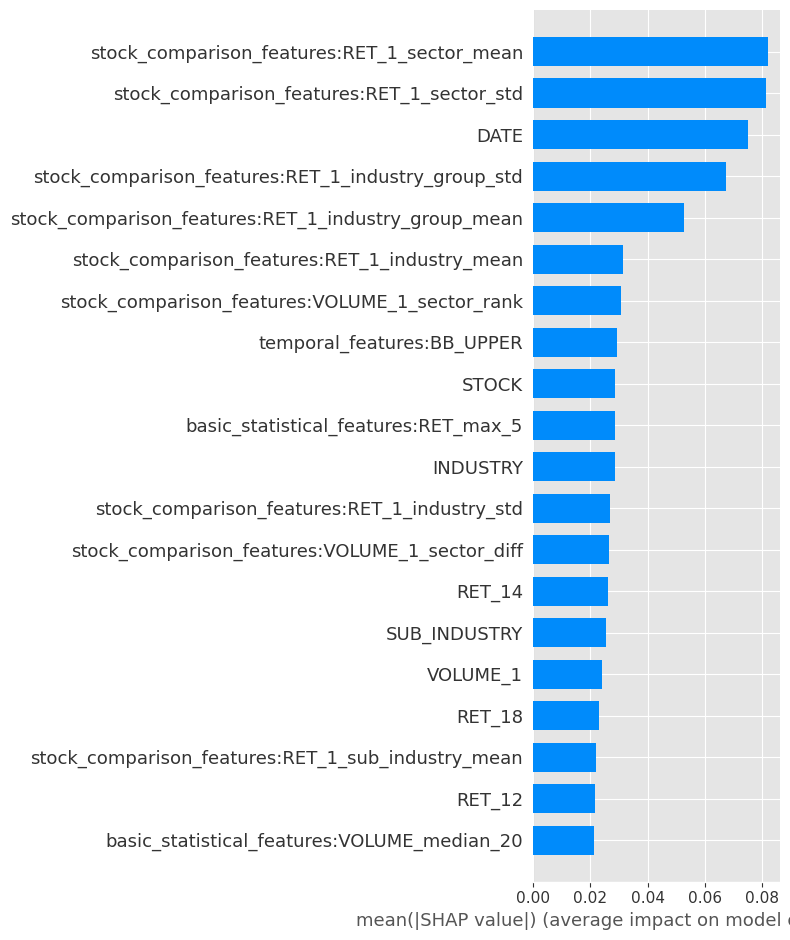

2025-04-01 23:04:12,262 - jhkaggle.feature_selection - INFO - Generating SHAP summary dot plot


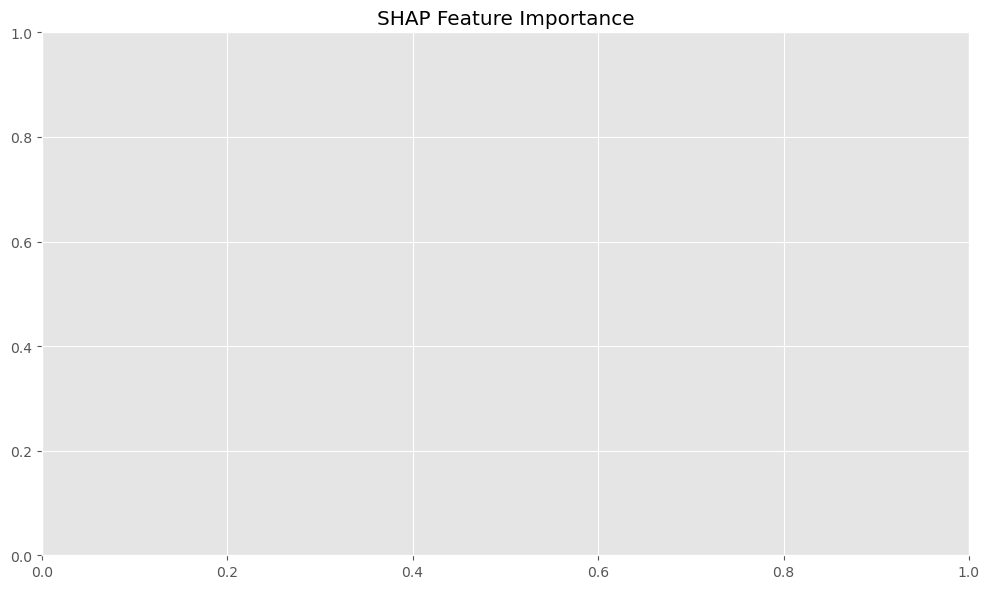

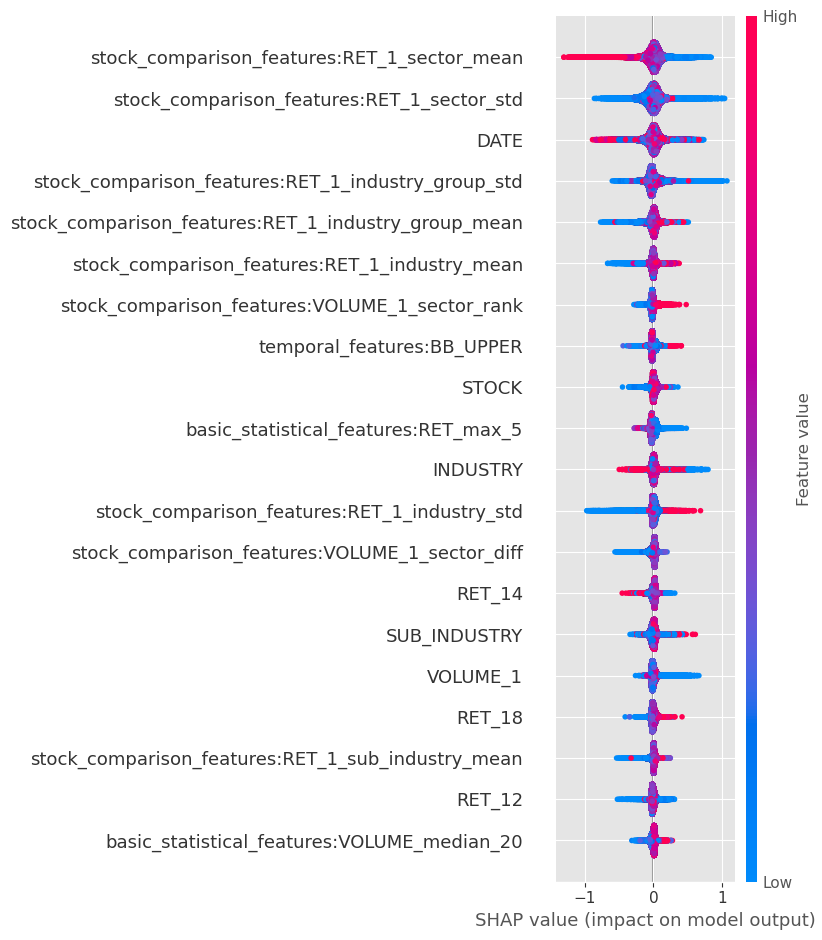

2025-04-01 23:05:06,927 - jhkaggle.feature_selection - INFO - SHAP analysis completed successfully
2025-04-01 23:05:06,940 - jhkaggle.feature_selection - INFO - Generating SHAP dependence plots for top 5 features
2025-04-01 23:05:06,942 - jhkaggle.feature_selection - INFO - SHAP dependence plots will be saved to C:\Users\Max\OneDrive\ULTRA NICE\ML Competition\QRT Challenge 2020\data\feature_selection/v1\feature_selection_20250401_225234\shap_dependence
2025-04-01 23:05:07,003 - jhkaggle.feature_selection - INFO - Top 5 features by SHAP importance: ['stock_comparison_features:RET_1_industry_group_mean', 'stock_comparison_features:RET_1_industry_group_std', 'DATE', 'stock_comparison_features:RET_1_sector_std', 'stock_comparison_features:RET_1_sector_mean']


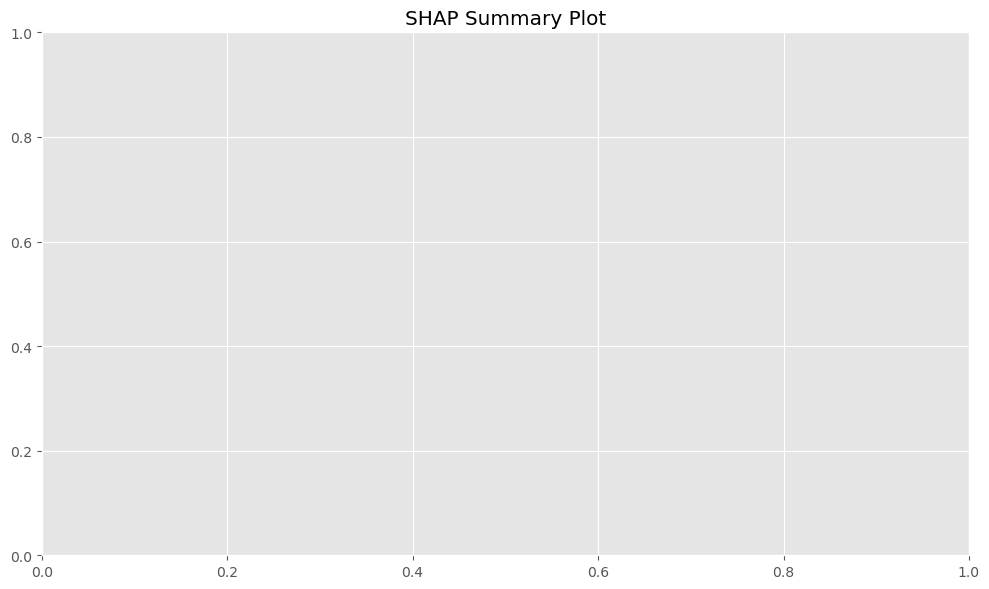

<Figure size 1000x700 with 0 Axes>

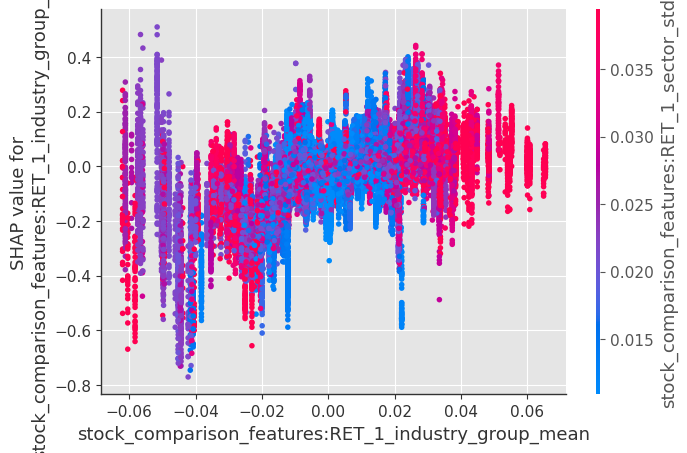

<Figure size 1000x700 with 0 Axes>

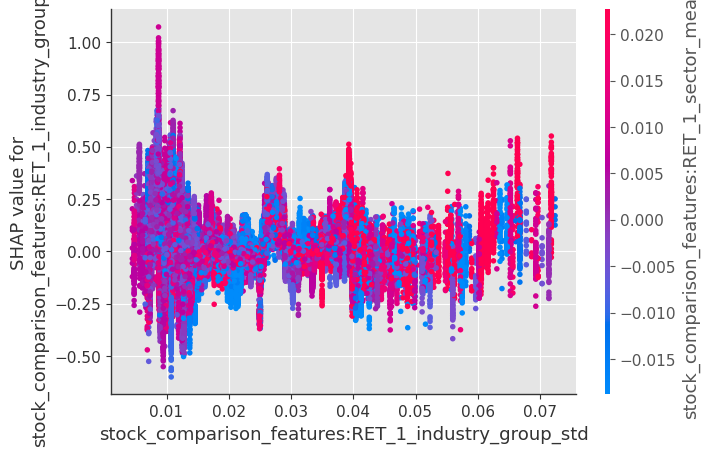

<Figure size 1000x700 with 0 Axes>

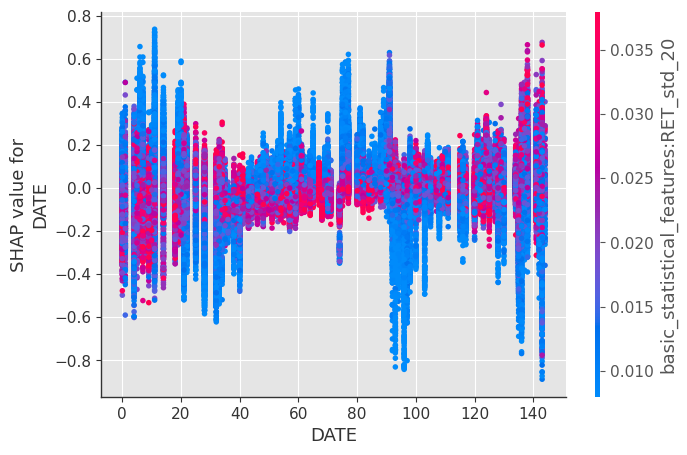

<Figure size 1000x700 with 0 Axes>

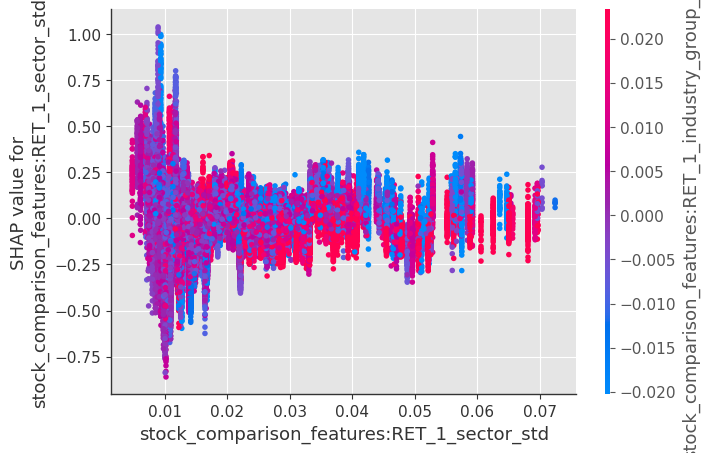

<Figure size 1000x700 with 0 Axes>

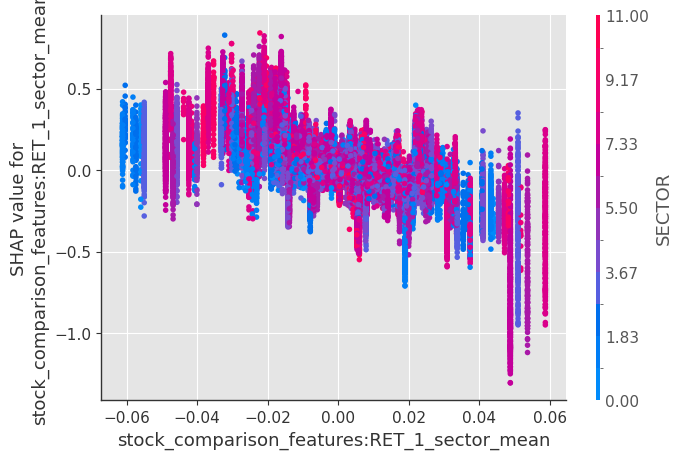

2025-04-01 23:06:01,735 - jhkaggle.feature_selection - INFO - SHAP dependence plots generated successfully


['stock_comparison_features:RET_1_industry_group_mean',
 'stock_comparison_features:RET_1_industry_group_std',
 'DATE',
 'stock_comparison_features:RET_1_sector_std',
 'stock_comparison_features:RET_1_sector_mean']

In [ ]:
# Get top K features by importance
top_features = fs.feature_importance.head(top_k)['Feature'].tolist()

# Generate and display SHAP analysis for top features
X_subset = fs.data[top_features].head(n_samples)
y_subset = fs.data[mlarchitect.mlarchitect_config['TARGET_NAME']].head(n_samples)

fs.generate_shap_analysis(X_subset, y_subset, plot=True)

# Generate dependence plots for top features
fs.generate_shap_dependence_plots(X_subset, top_n=5)

## Step 8: Calculate Feature Interaction Correlations

SHAP values can reveal how features interact with each other in the model. The "best interaction" between features is often determined by finding the feature that most strongly correlates with the SHAP values of another feature.

This next step calculates the correlation between each feature's SHAP values and the values of all other features to identify the strongest interactions in the model.

In [14]:
# Create a function to find the strongest interaction for each feature
def find_strongest_interactions(X, shap_values, top_n=None):
    """
    For each feature, find the other features that most strongly interact with it
    based on correlation between SHAP values and feature values.
    
    Parameters:
    - X: DataFrame containing feature values
    - shap_values: SHAP values array
    - top_n: Number of top features to analyze (default: use all features from X)
    
    Returns:
    - DataFrame with feature interactions
    """
    feature_names = X.columns
    n_features = len(feature_names) if top_n is None else min(top_n, len(feature_names))
    results = []
    
    # Get feature importance to select top features
    feature_importance = np.abs(shap_values).mean(0)
    top_indices = np.argsort(-feature_importance)[:n_features]
    top_features = [feature_names[i] for i in top_indices]
    
    print(f"Finding strongest interactions for {len(top_features)} features...")
    
    # For each top feature, find the feature that most strongly interacts with it
    for i, feature in enumerate(top_features):
        feature_idx = list(feature_names).index(feature)
        feature_shap = shap_values[:, feature_idx]
        
        max_abs_corr = 0
        best_interaction = None
        interaction_corr = 0
        interaction_type = ''
        
        # Loop through all other features to find strongest correlation
        for other_feature in feature_names:
            if other_feature == feature:
                continue
                
            other_values = X[other_feature].values
            
            # Calculate different types of correlations
            linear_corr = np.corrcoef(other_values, feature_shap)[0, 1]
            abs_other_values = np.abs(other_values)
            abs_corr = np.corrcoef(abs_other_values, np.abs(feature_shap))[0, 1] if not np.isnan(abs_other_values).any() else 0
            
            # Try squared and log transformations for non-linear relationships
            other_values_squared = other_values**2
            squared_corr = np.corrcoef(other_values_squared, feature_shap)[0, 1] if not np.isnan(other_values_squared).any() else 0
            
            # Use log(1+|x|) to handle zeros and negative values
            log_values = np.log1p(np.abs(other_values))
            log_corr = np.corrcoef(log_values, feature_shap)[0, 1] if not np.isnan(log_values).any() else 0
            
            # Take the strongest correlation among all types
            corrs = {
                'linear': abs(linear_corr),
                'absolute': abs(abs_corr),
                'squared': abs(squared_corr),
                'log': abs(log_corr)
            }
            
            max_corr_type = max(corrs, key=corrs.get)
            max_corr = corrs[max_corr_type]
            
            if max_corr > max_abs_corr and not np.isnan(max_corr):
                max_abs_corr = max_corr
                best_interaction = other_feature
                interaction_type = max_corr_type
                
                # Store the actual correlation value (with sign) based on the type
                if max_corr_type == 'linear':
                    interaction_corr = linear_corr
                elif max_corr_type == 'absolute':
                    interaction_corr = abs_corr
                elif max_corr_type == 'squared':
                    interaction_corr = squared_corr
                else:  # log
                    interaction_corr = log_corr
        
        # Store the results for this feature
        results.append({
            'Feature': feature,
            'Best_Interaction': best_interaction,
            'Interaction_Correlation': interaction_corr,
            'Abs_Correlation': max_abs_corr,
            'Interaction_Type': interaction_type,
            'SHAP_Importance': feature_importance[feature_idx]
        })
    
    # Convert to DataFrame and sort by interaction strength
    interaction_df = pd.DataFrame(results)
    interaction_df = interaction_df.sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)
    return interaction_df

# Calculate feature interactions if SHAP values are available
if shap_values is not None:
    print(f"Analyzing interactions for top features using {n_samples} samples...")
    interaction_df = find_strongest_interactions(
        X=X_subset, 
        shap_values=shap_values
    )
    
    # Display the top interactions
    print("\nTop Feature Interactions:")
    display(interaction_df.head(15))  # Show only top 15 interactions for readability
    
    # Analyze how interaction strength relates to feature importance
    plt.figure(figsize=(10, 6))
    plt.scatter(interaction_df['SHAP_Importance'], interaction_df['Abs_Correlation'], alpha=0.7)
    plt.xlabel('SHAP Importance')
    plt.ylabel('Interaction Strength (Correlation)')
    plt.title('Feature Importance vs. Interaction Strength')
    plt.grid(True, alpha=0.3)
    
# Add annotations for strongest interactions
    for i, row in interaction_df.head(5).iterrows():
        plt.annotate(row['Feature'], 
                     (row['SHAP_Importance'], row['Abs_Correlation']),
                     xytext=(5, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()
    
    # Create enhanced dependence plots for top 5 interactions
    print("\n" + "-"*50)
    print("Creating enhanced dependence plots for top 5 feature interactions:")
    print("-"*50)
    
    for i, row in interaction_df.head(5).iterrows():
        feature = row['Feature']
        interaction = row['Best_Interaction']
        corr_type = row['Interaction_Type']
        corr_value = row['Interaction_Correlation']
        
        plt.figure(figsize=(12, 6))
        
        # Create dependence plot with explicit interaction feature
        shap.dependence_plot(
            feature, 
            shap_values, 
            X_subset, 
            interaction_index=interaction,
            show=False
        )
        
        # Format correlation value for title
        corr_sign = '+' if corr_value > 0 else ''
        
        plt.title(
            f"SHAP Dependence Plot: {feature}\n"
            f"Best interaction with {interaction} ({corr_type} correlation: {corr_sign}{corr_value:.3f})",
            fontsize=13
        )
        plt.tight_layout()
        plt.show()
else:
    print("Cannot analyze feature interactions: SHAP values not available")

Analyzing interactions for top features using 200000 samples...
Finding strongest interactions for 150 features...


KeyboardInterrupt: 